# mp2gazeデータセット中の画像を，カメラと視線があっているものとそうでないものに分ける 

- データセットの整備 (アノテーションファイルが２箇所に散らばっている上に画像との対応が取りづらいのでjson形式に変換する)

- データセット中の画像をlocked, unlockedに分ける
    - 正規化された画像に対するアノテーションの中に3次元視線方向がある
    - 論文によると3次元視線方向を2次元にマッピングして(0,0)の点をlockedにしている

In [8]:
import os
import shutil
import json
import scipy.io

## データセットの整備 (画像パス -> その画像へのアノテーション のdictを作る)

### datasetの概要
データが入っているフォルダ /Data
オリジナル画像 (以下orig)とそれに対するアノテーションが入っているフォルダ /Data/Original
正規化された画像 (以下norm)とそれに対するアノテーションが入っているフォルダ /Data/Normalized

origのフォルダ構成は"person_id/day_id/*"となっている
*のところには画像"XXXX.jpg"と，annotation.txtが入る
annotation.txtの1行目が"0001.jpg"に対するアノテーションとなっている

normのフォルダ構成は"person_id/dayXX.mat"となっている
origとは違い，アノテーションと画像はmatファイルとして保存されている

normのmatファイルはpythonのscipy.io.loadmatでndarrayとして読みこむことができる
matファイルには，両目の正規化された画像とその画像に対するアノテーション (視線の3次元方向と顔向き?の3次元方向ベクトル)が含まれている
mat['data'][0][0][eye_id][0][0][ant_id]でデータにアクセスできる
eye_idは{'右目': 0, '左目': 1}で
ant_idは{'gaze': 0, 'image': 1, 'pose': 2}
である．

### original画像に対するアノテーションの各要素の説明
- Dimension 1~24: Detected eye landmarks position in pixel on the whole image coordinate
- Dimension 25~26: On-screen gaze target position in screen coordinate
- Dimension 27~29: 3D gaze target position related to camera
- Dimension 30~35: The estimated 3D head pose based on 6 points-based 3D face model, rotation and translation: we implement the same 6 points-based 3D face model in [3], which includes the four eye corners and two mouth corners
- Dimension 36~38: The estimated 3D right eye center in the camera coordiante system.
- Dimension 39~41: The estimated 3D left eye center in the camera cooridnate system.
 

In [9]:
# 複数の画像のアノテーションをまとめて保持するdictからn番目の画像に対するアノテーションのみをもつdictをつくる
# 深さは2で固定
def extract_nth_ant(dic, n):
    result = {}
    for k1, dic2 in dic.items():
        result[k1] = {}
        for k2, dic3 in dic2.items():
            if n >= len(dic3):
                return None
            else:
                result[k1][k2] = dic3[n].tolist()
    return result

def load_mat_ants_as_dict(path):
    mat = scipy.io.loadmat(path)
    norm_ants = {}
    key_dict1 = {'right': 0, 'left': 1}
#     imageを含めるとjsonファイルが大きくなりすぎるので除く
#     key_dict2 = {'gaze': 0, 'image': 1, 'pose': 2}
    key_dict2 = {'gaze': 0, 'pose': 2}
    for k1, v1 in key_dict1.items():
        norm_ants[k1] = {}
        for k2, v2 in key_dict2.items():
            norm_ants[k1][k2] = mat['data'][0][0][v1][0][0][v2]
    return norm_ants

In [10]:
mp_data_dir = '../data/gaze_dataset/MPIIGaze/Data'
mp_orig_dir = os.path.join(mp_data_dir, 'Original')
mp_norm_dir = os.path.join(mp_data_dir, 'Normalized')

dic = {}
person_ids = sorted(os.listdir(mp_orig_dir))

for person_id in person_ids:
    dic[person_id] = {}
    day_ids = sorted([name for name in os.listdir(os.path.join(mp_orig_dir, person_id)) if name[:3] == 'day'])

    for day_id in day_ids:
        dic[person_id][day_id] = {}
        
        #   一つ目のアノテーションファイルを読み込む (.txt)
        orig_ants_path = os.path.join(mp_orig_dir, person_id, day_id, 'annotation.txt')
        with open(orig_ants_path, 'r') as fr:
            orig_ants = fr.readlines()
        #  二つ目のアノテーションファイルを読み込み (.mat)        
        norm_ants_path = os.path.join(mp_norm_dir, person_id, '%s.mat' % day_id)
        norm_ants = load_mat_ants_as_dict(norm_ants_path)
        
        img_names  = sorted([name for name in os.listdir(os.path.join(mp_orig_dir, person_id, day_id)) if name[-4:] == '.jpg'])     
       
        for i, img_name in enumerate(img_names):
            # アノテーションされていないことがあるのでindexをチェックしてannotation.txtの行数を超えたら次のdayにうつる
            
            dic[person_id][day_id][img_name] = {}
            dic[person_id][day_id][img_name]['original'] = []
            if i < len(orig_ants):
                dic[person_id][day_id][img_name]['original'] = orig_ants[i].strip().split()
            norm_dic = extract_nth_ant(norm_ants, i)
            dic[person_id][day_id][img_name]['normalized'] = {}
            if norm_dic:
                dic[person_id][day_id][img_name]['normalized'] = norm_dic

### jsonファイルに書き出す（他に使うかもなので）

In [168]:
with open('../data/gaze_dataset/mp2gaze_annotation.json', 'w') as fw:
    json.dump(dic, fw, indent=2, sort_keys=True)

## 3次元方向を2次元方向にマッピングして(0,0)に近いやつを探して画像を見てみる

In [ ]:
import math
import json

from IPython.display import display, Image
import cv2

def imshow(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))
    
def imshow_path(image_path, format='.png'):
    img = cv2.imread(image_path)
    imshow(img, format)

locked_path_list = []
unlocked_path_list = []
th = 0.1
for person in sorted(dic.keys()):
    for day in sorted(dic[person].keys()):
        for image in sorted(dic[person][day].keys()):
            img_path = os.path.join(mp_orig_dir, person, day, image)
            
            xyz = [float(s) for s in dic[person][day][image]['original'][26:29]]
            locked = bool([n for n in xyz if abs(n) < th])
            if locked:
                locked_path_list.append(img_path)
            else:
                unlocked_path_list.append(img_path)
            
#             ant = dic[person][day][image]['normalized']
#             if 'right' not in ant or 'left' not in ant:
#                 break
#             right_gaze = ant['right']['gaze']
#             left_gaze = ant['left']['gaze']
#             r_theta, r_phi = math.asin(-right_gaze[1]), math.atan2(-right_gaze[0], -right_gaze[2])
#             l_theta, l_phi = math.asin(-left_gaze[1]), math.atan2(-left_gaze[0], -left_gaze[2])
#             eye_dirs = [r_theta, r_phi, l_theta, l_phi]
#             # 全ての値の絶対値が閾値より小さいならTrue, それ以外はFalse
#             locked = bool([eye_dir for eye_dir in eye_dirs if abs(eye_dir) < th])
#             img_path = os.path.join(mp_orig_dir, person, day, image)
#             if locked:
#                 locked_path_list.append(img_path)
#             else:
#                 unlocked_path_list.append(img_path)
print('completed.')

In [71]:
print(len(locked_path_list))
print(len(unlocked_path_list))

5
218152


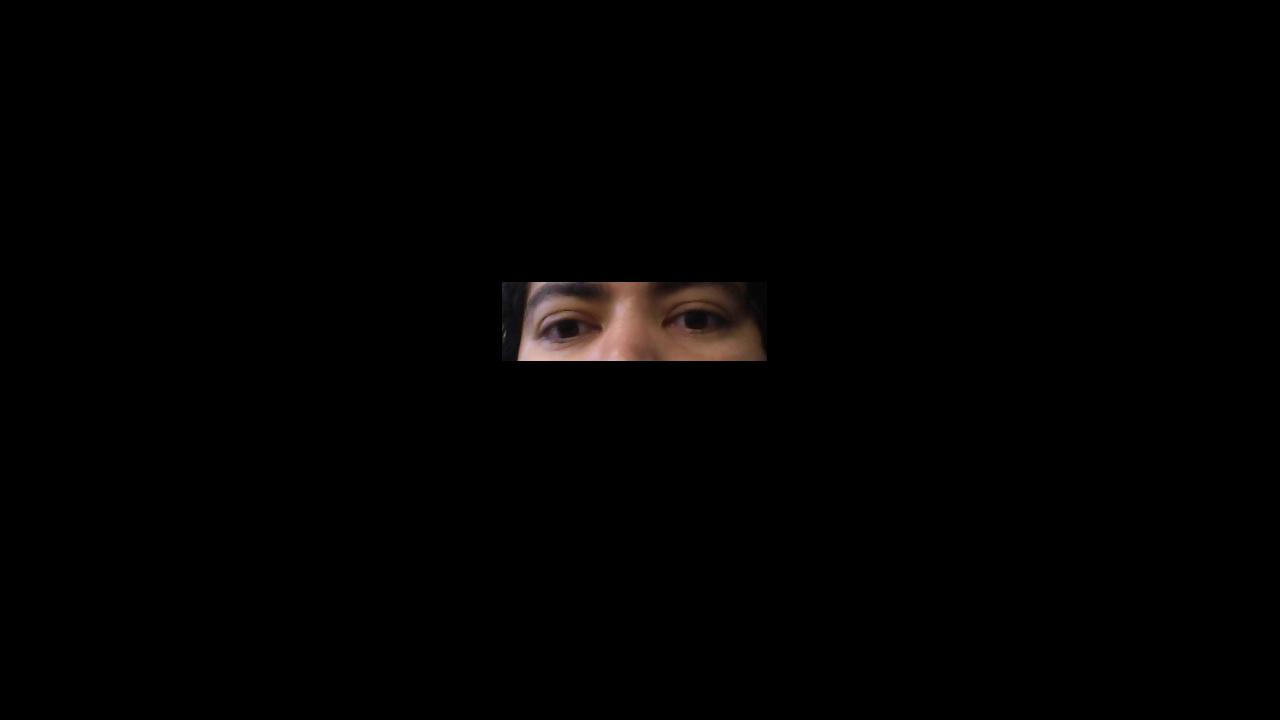

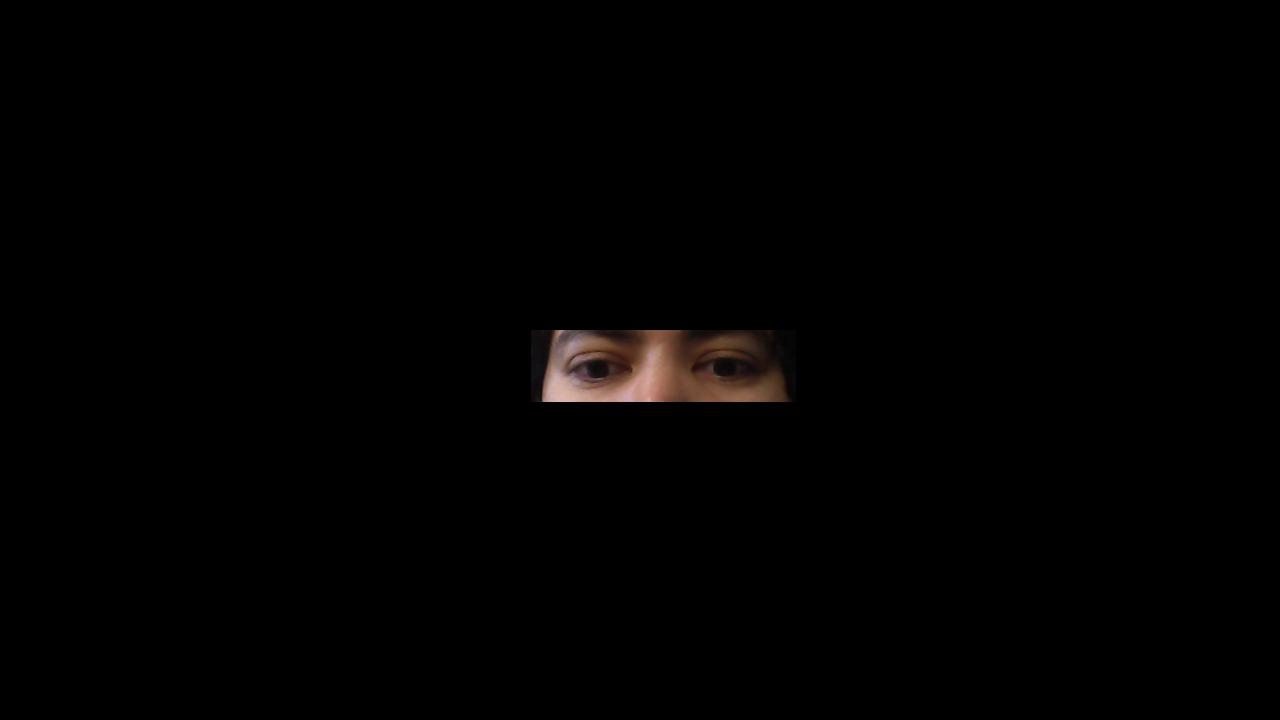

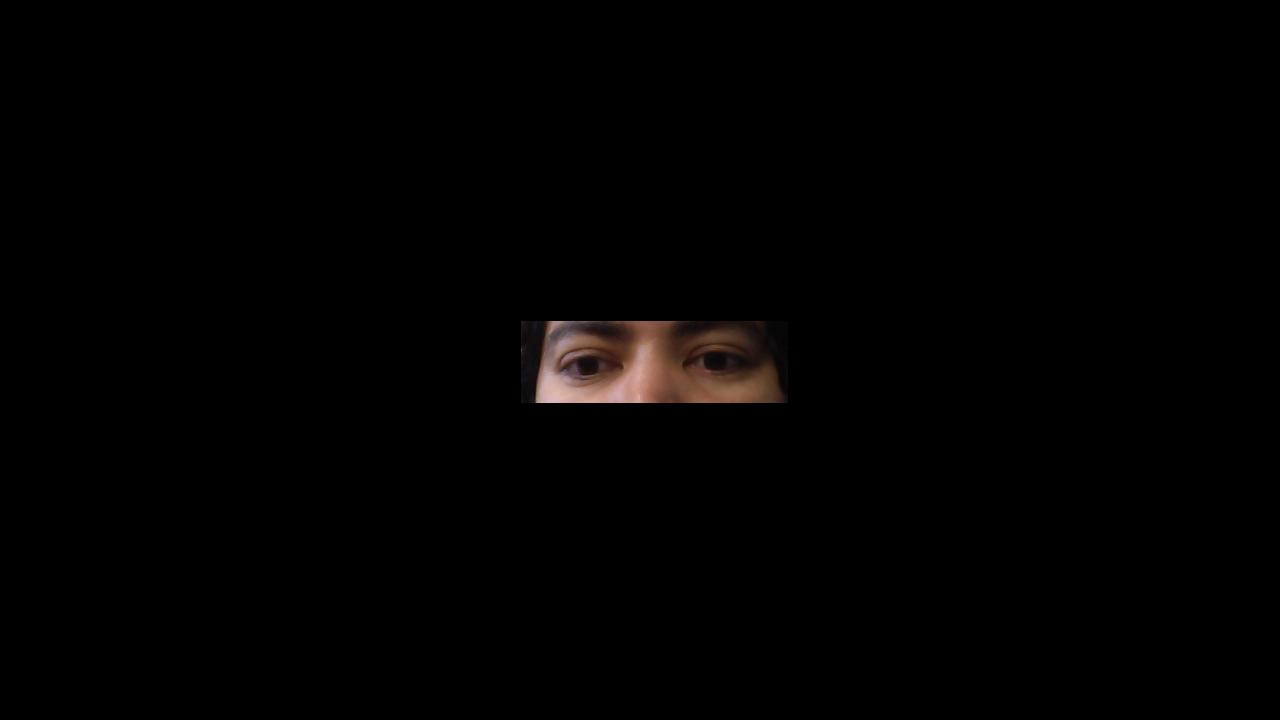

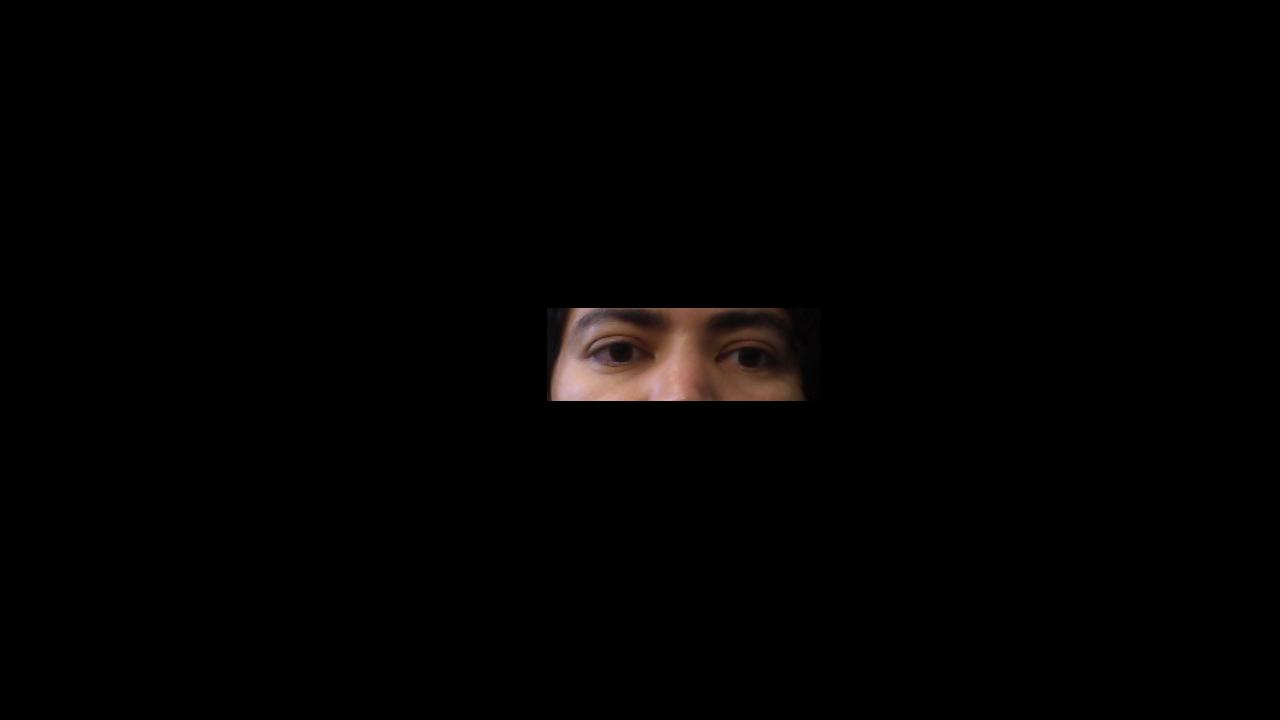

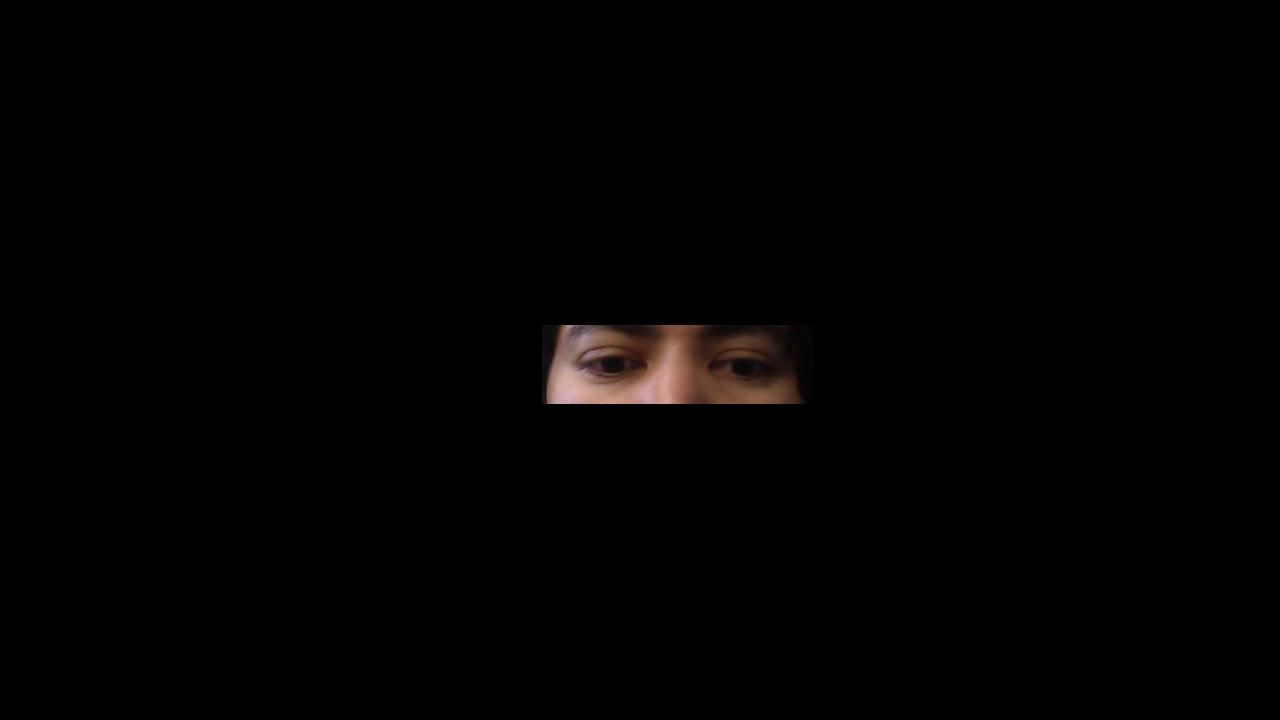

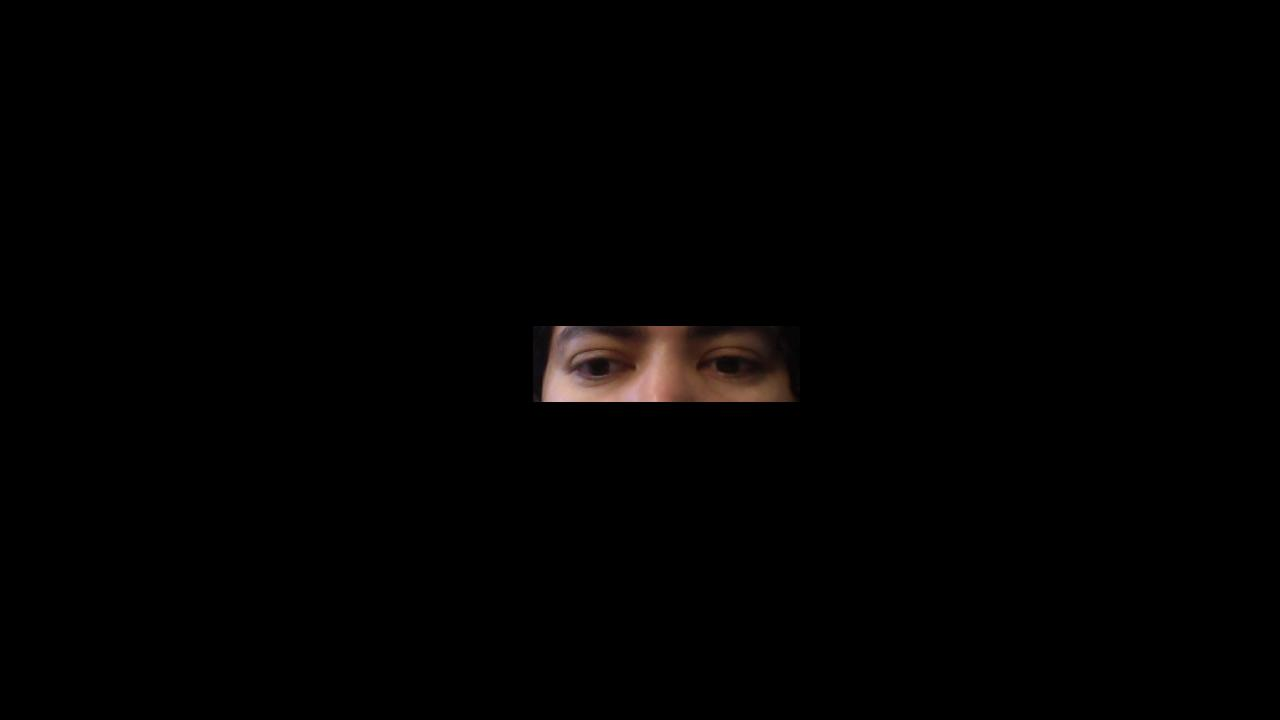

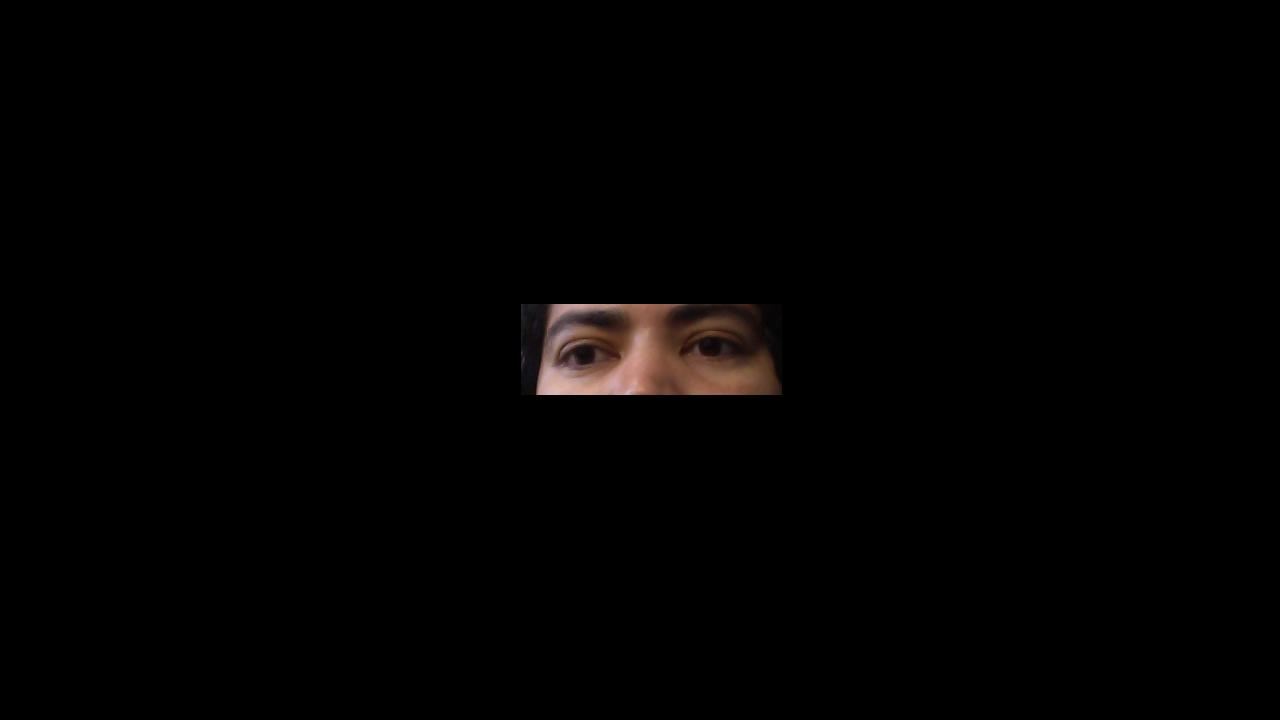

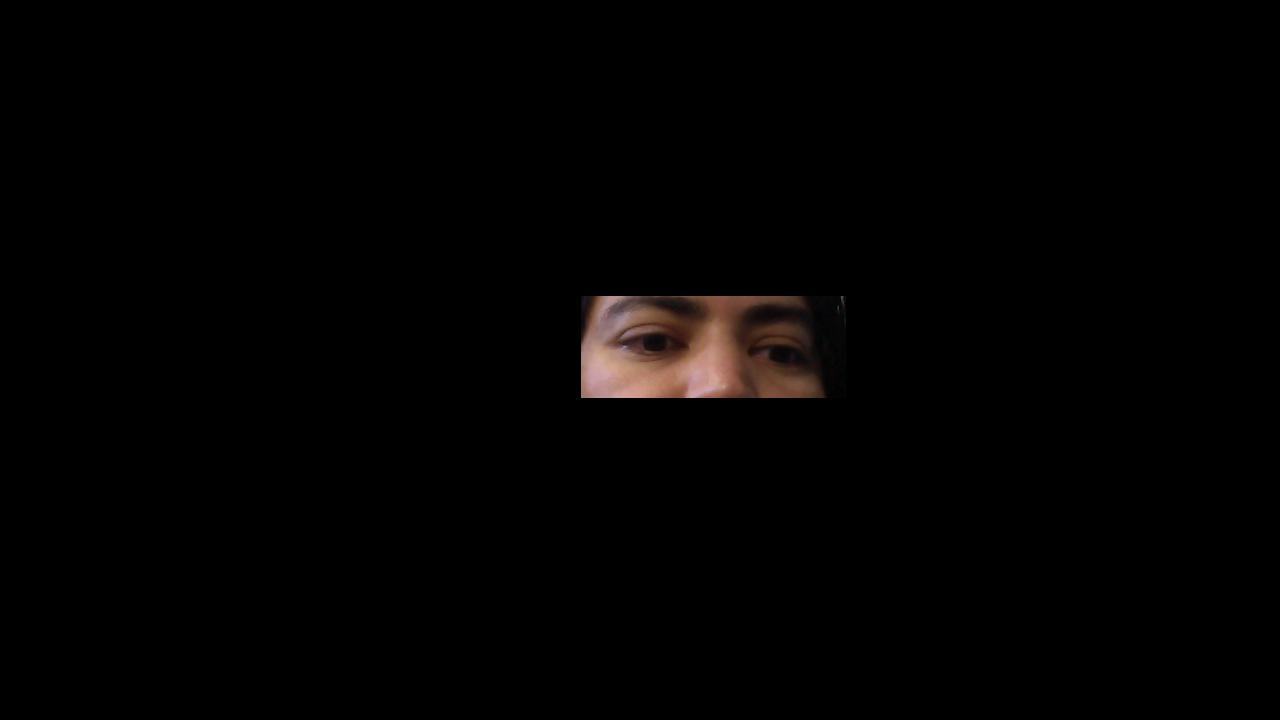

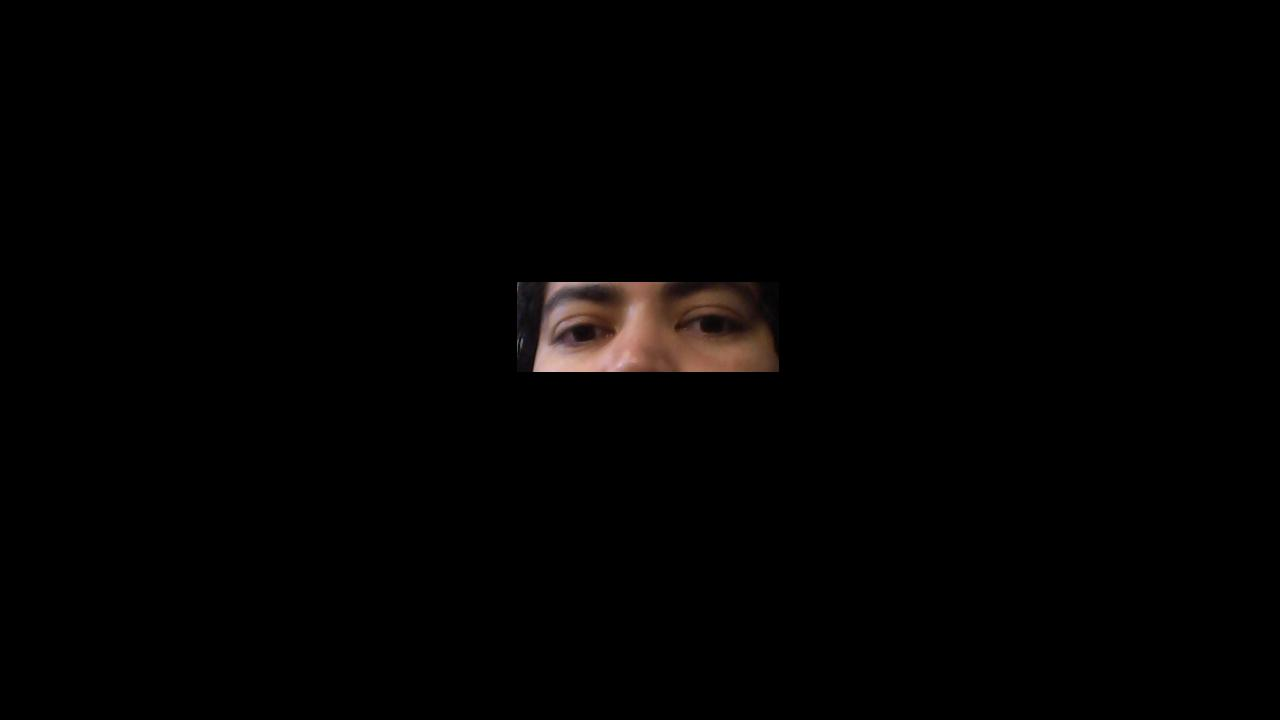

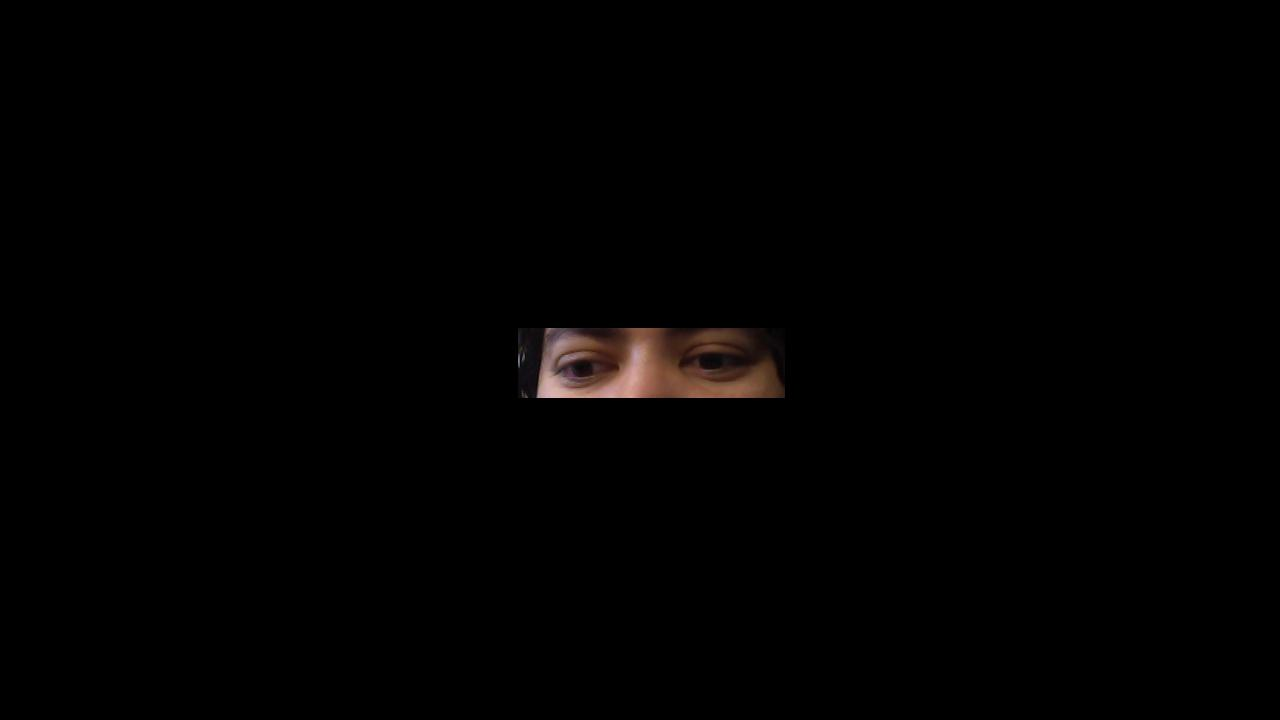

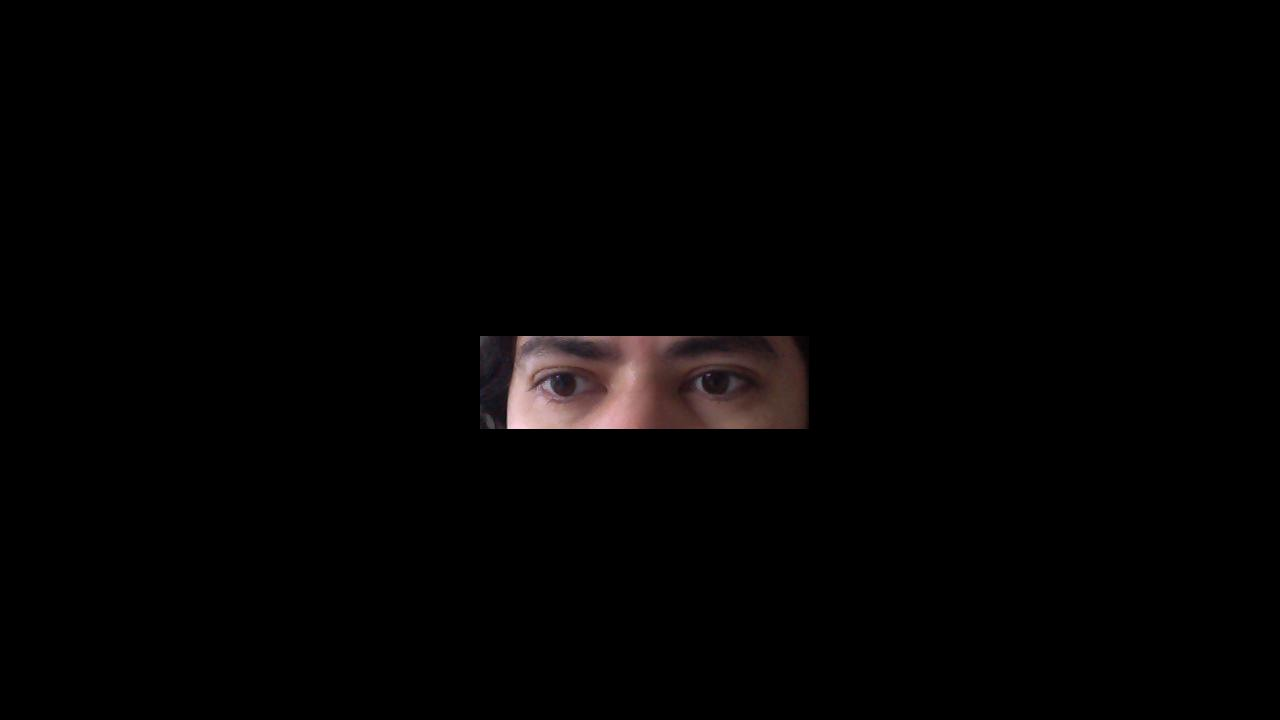

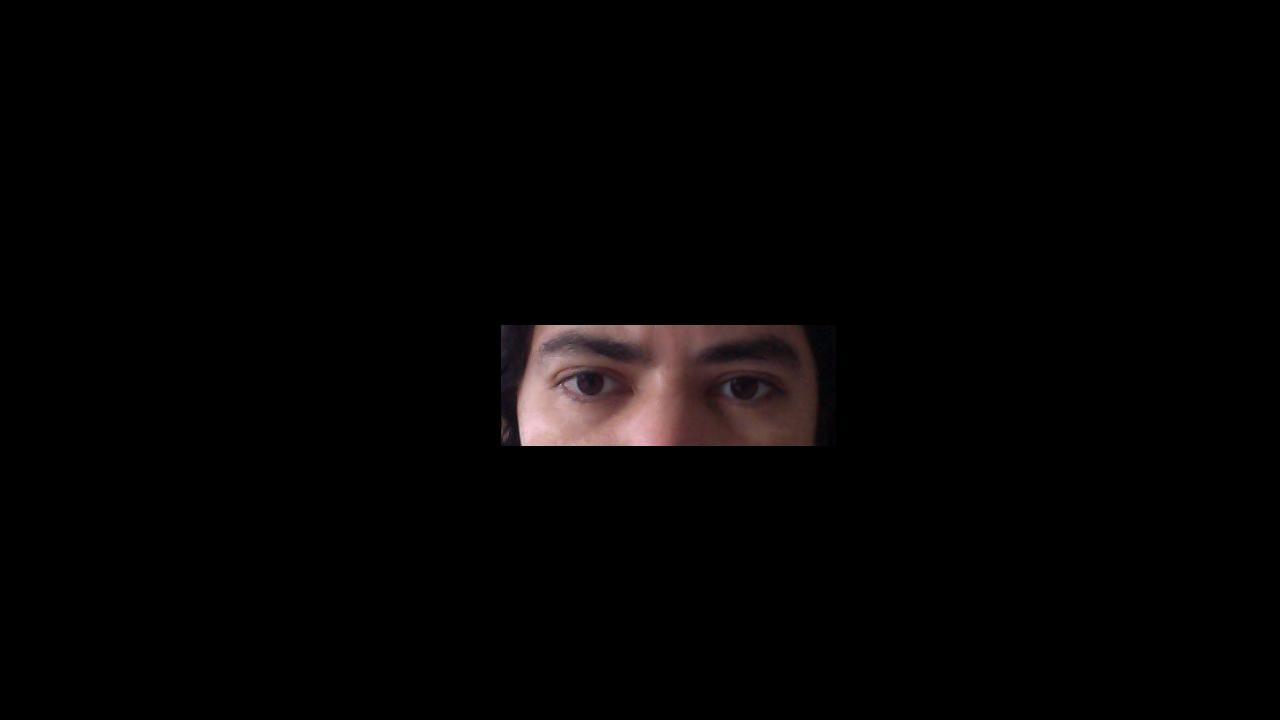

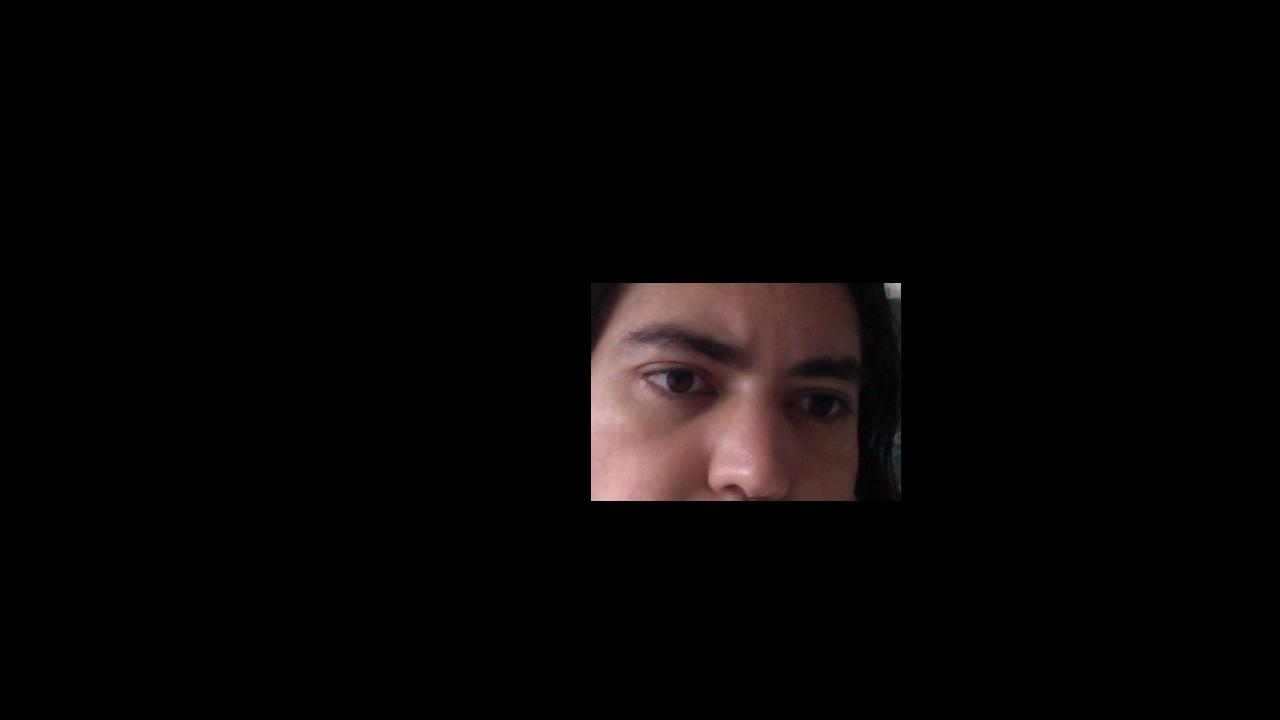

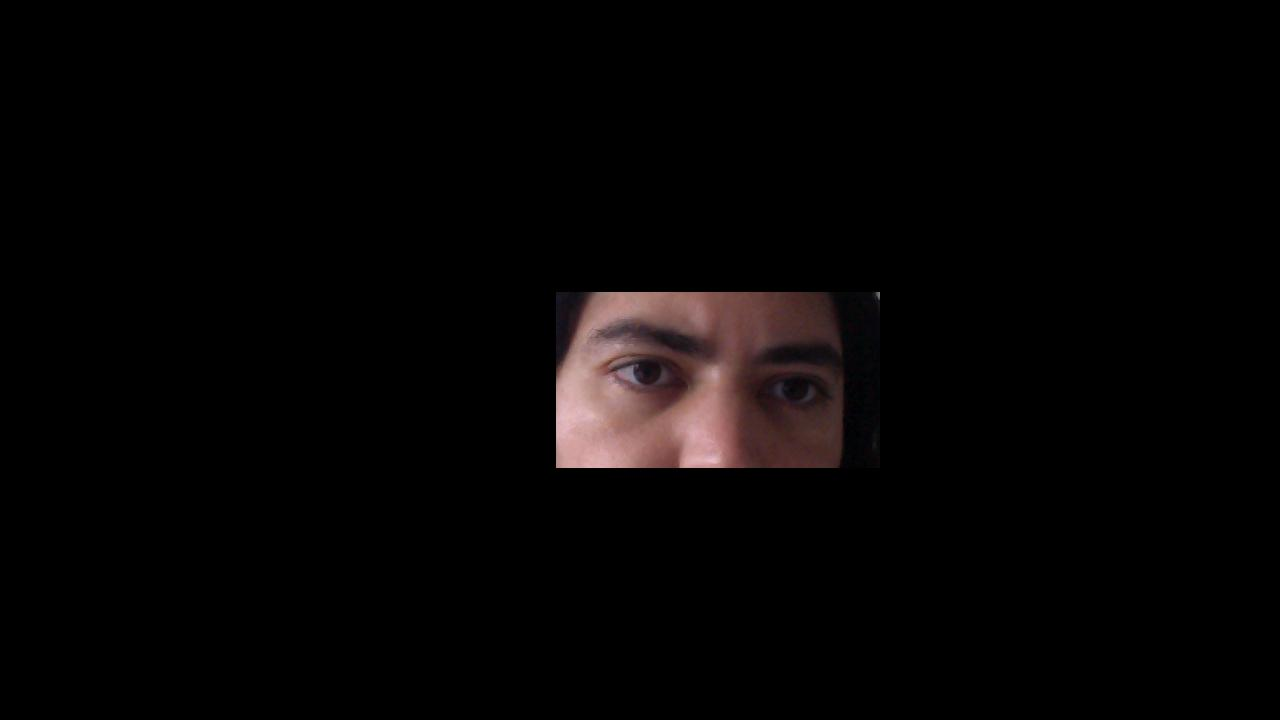

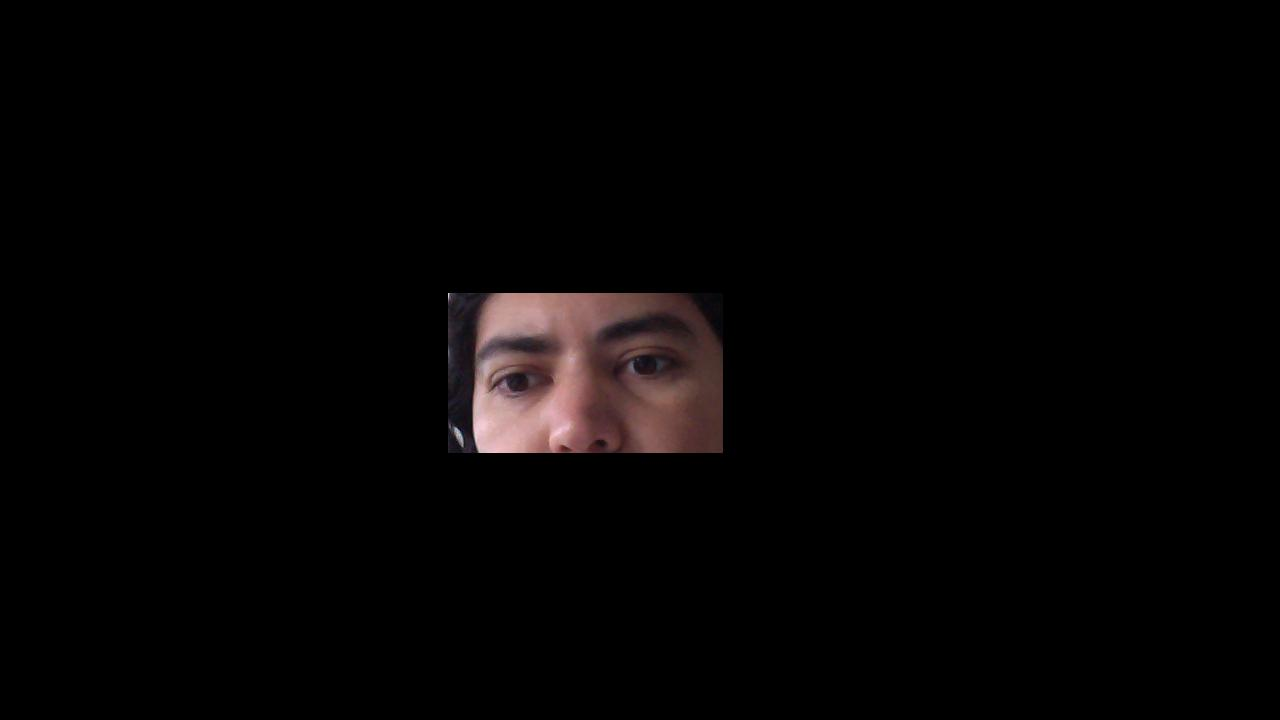

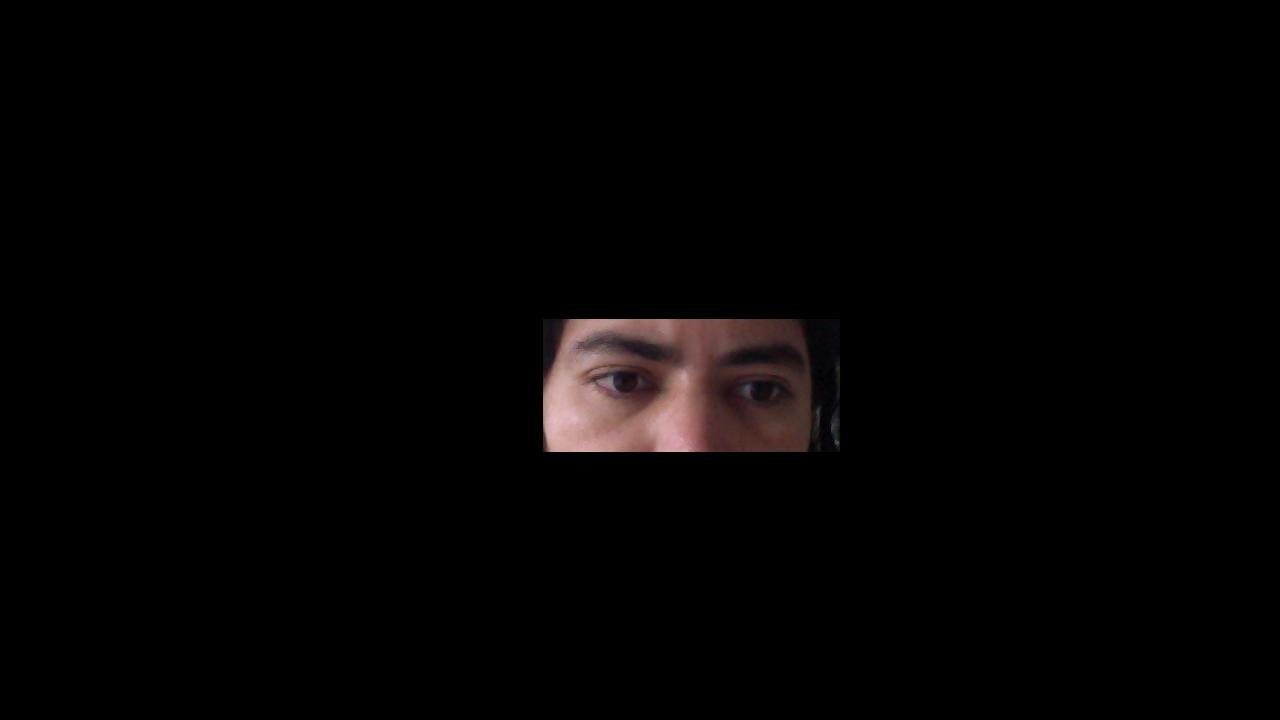

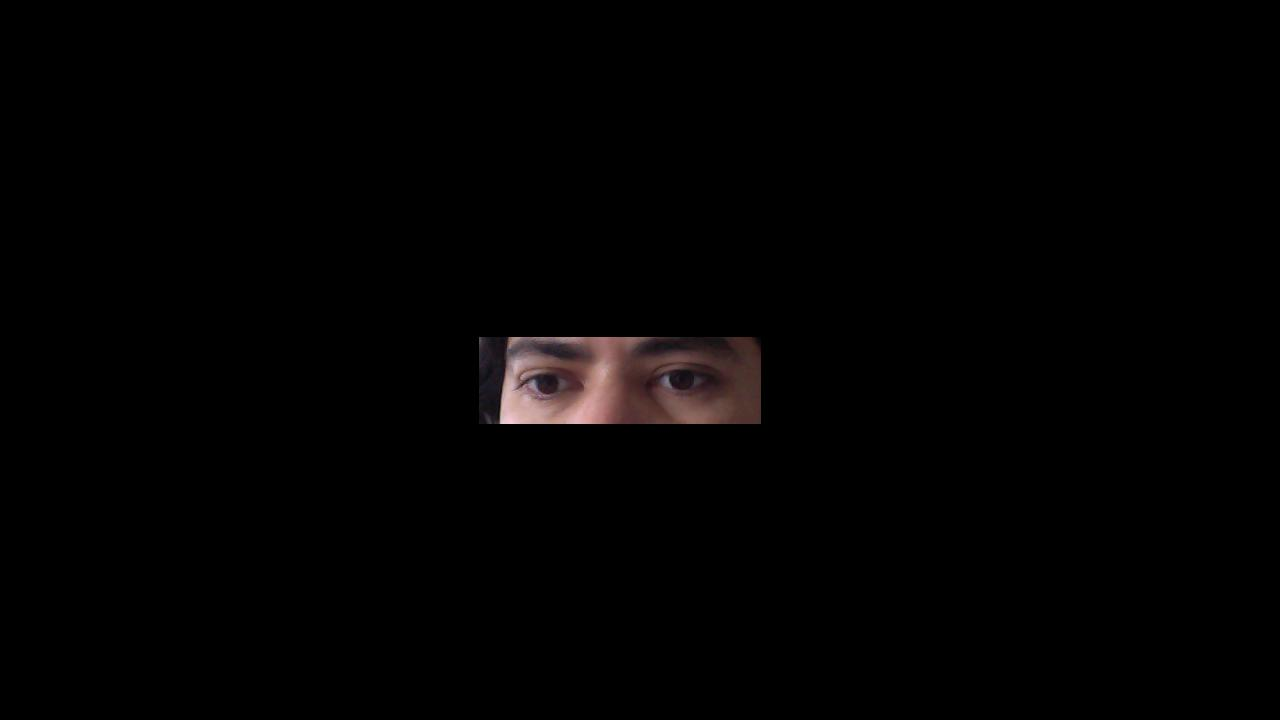

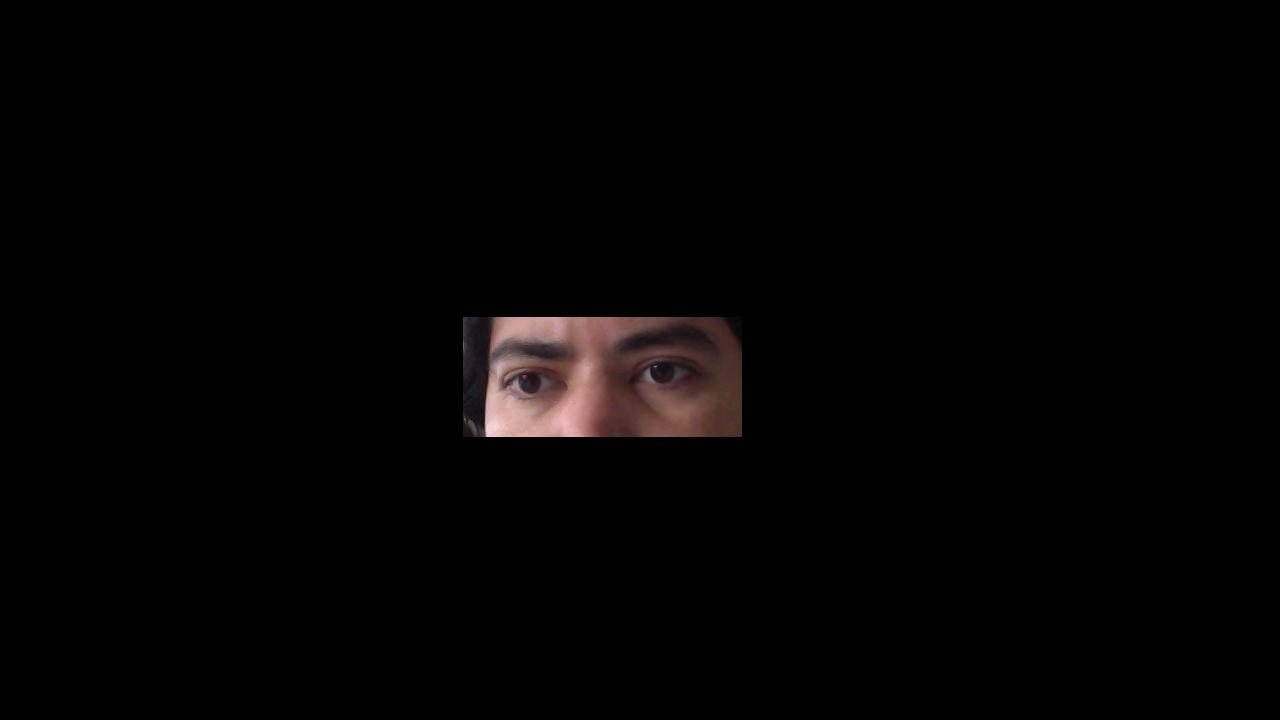

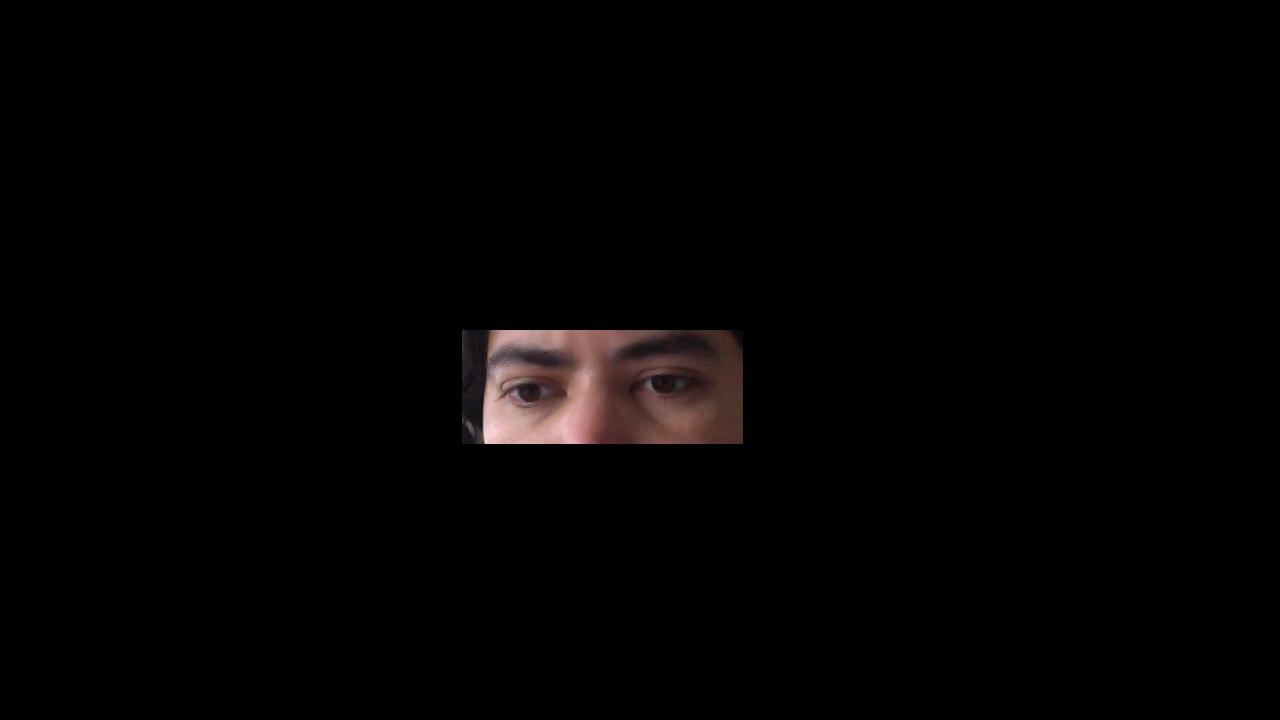

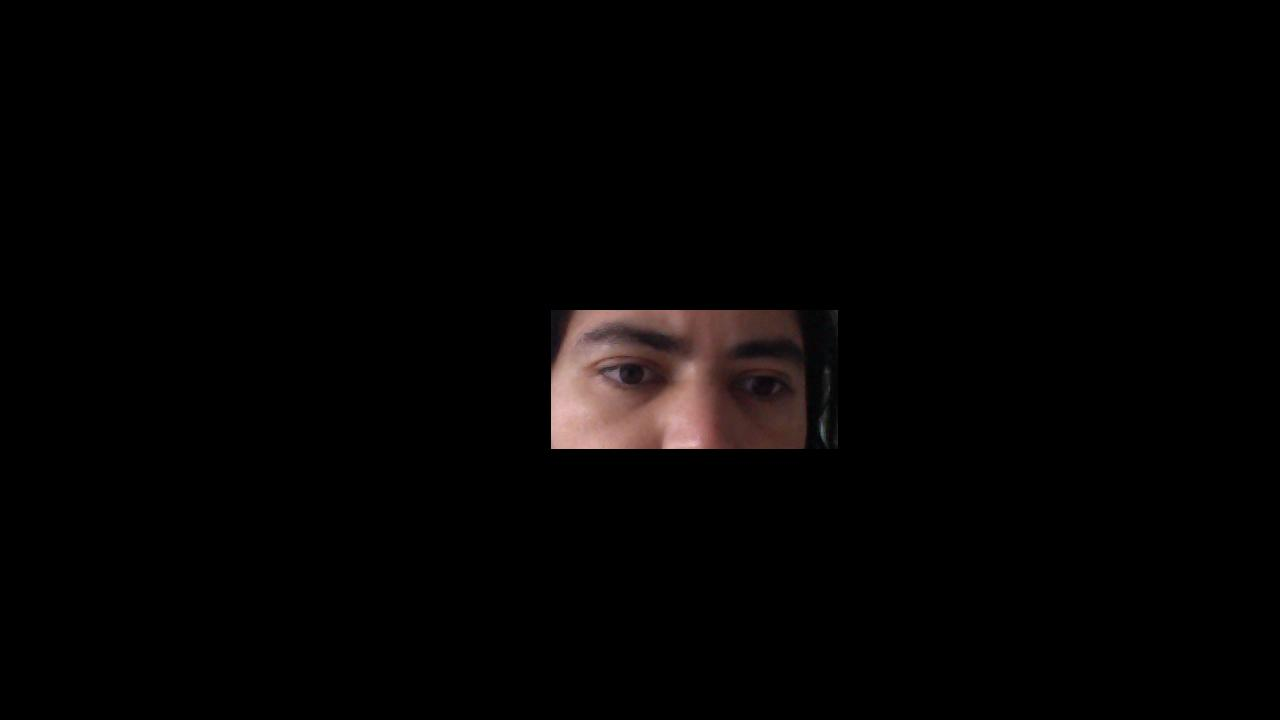

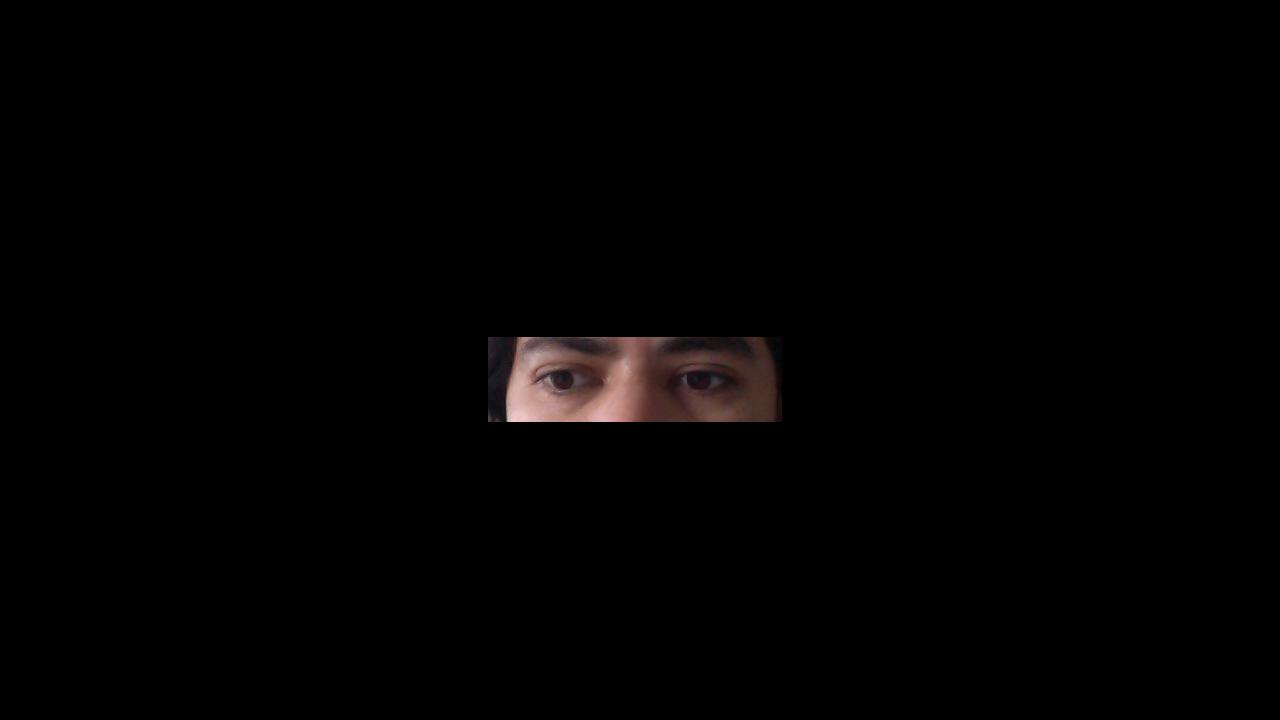

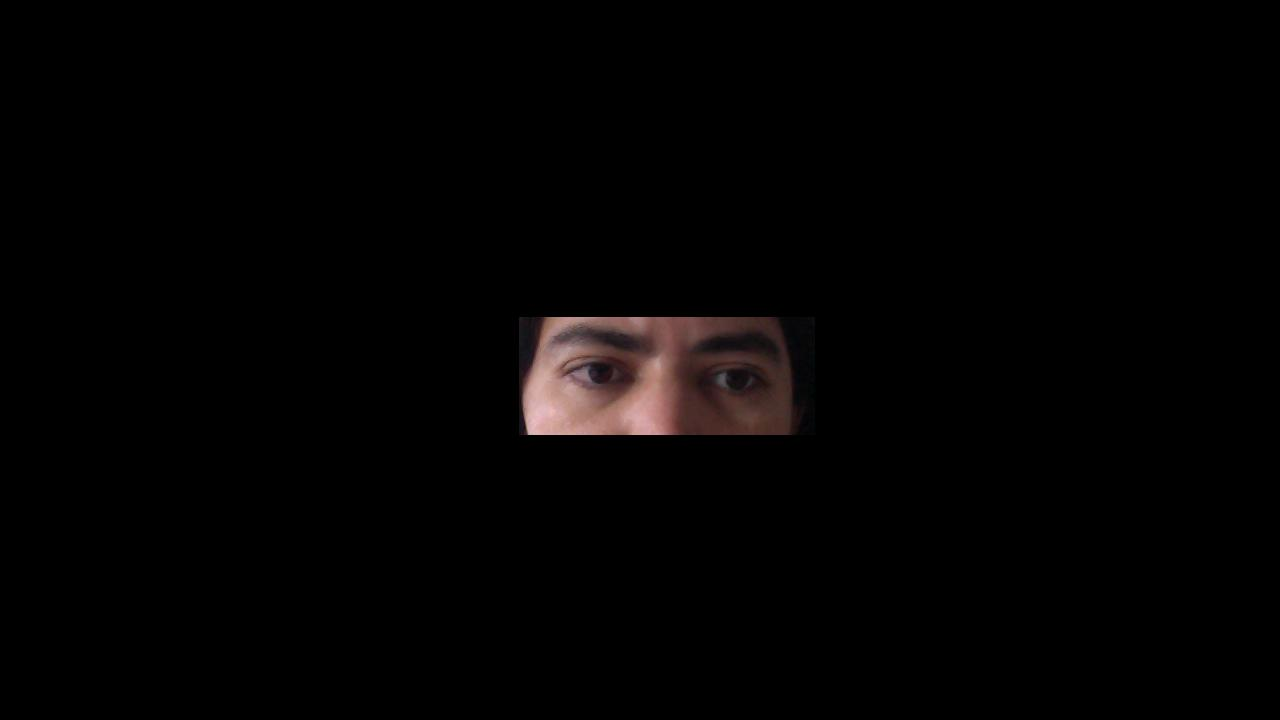

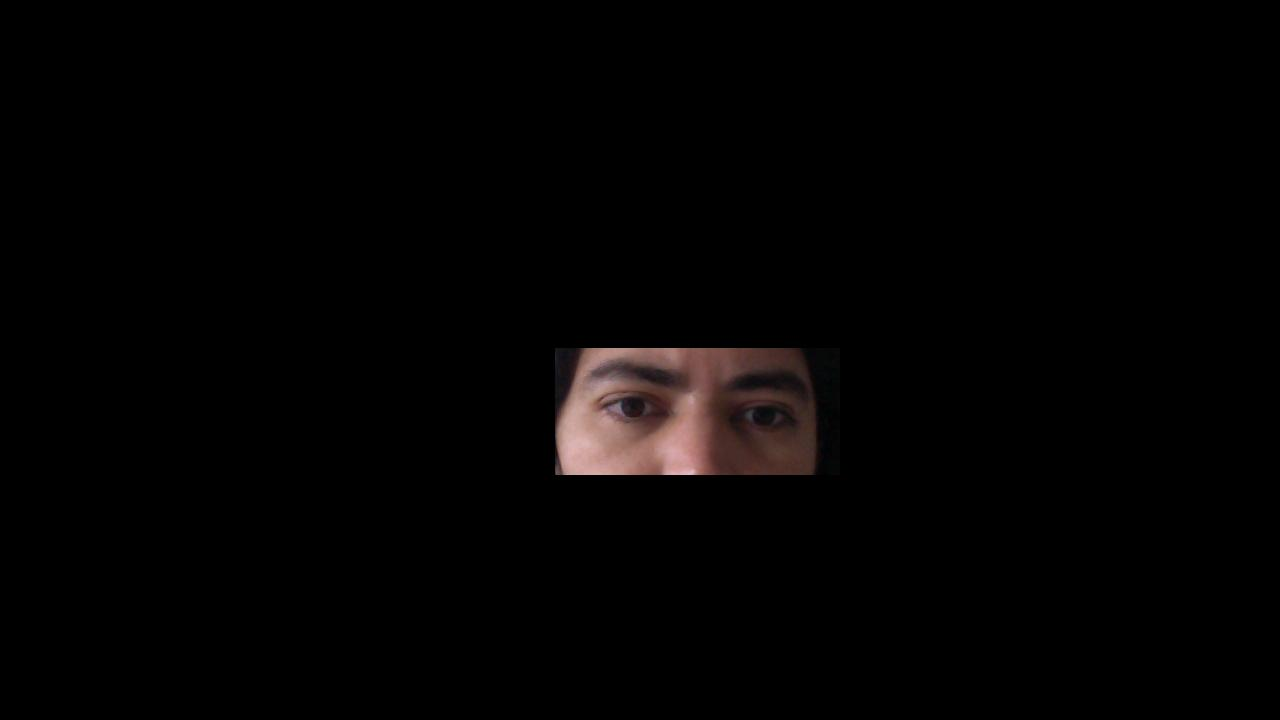

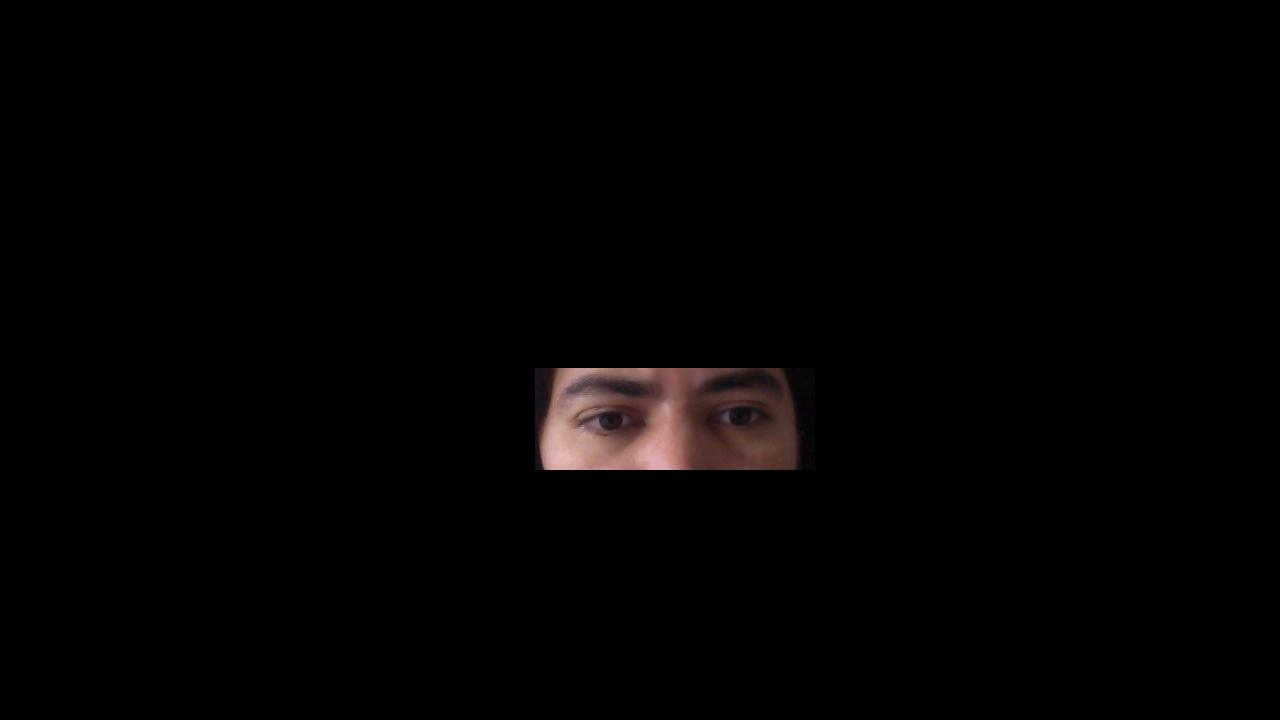

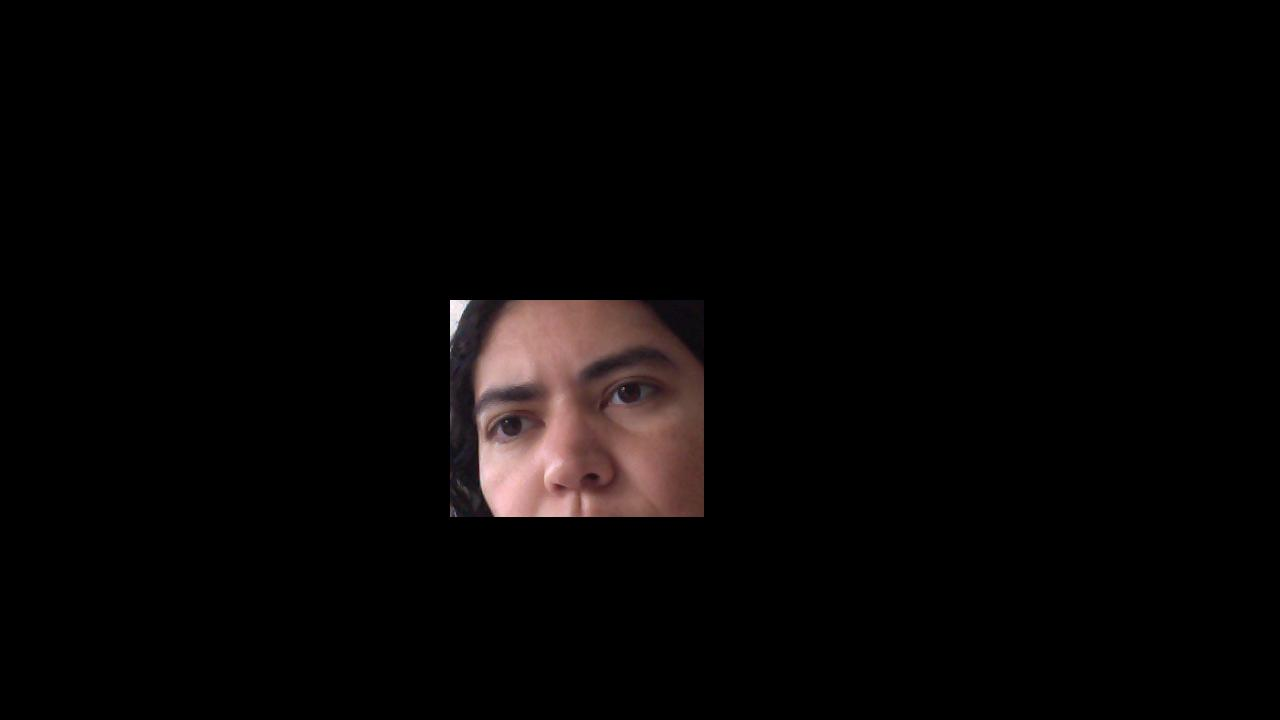

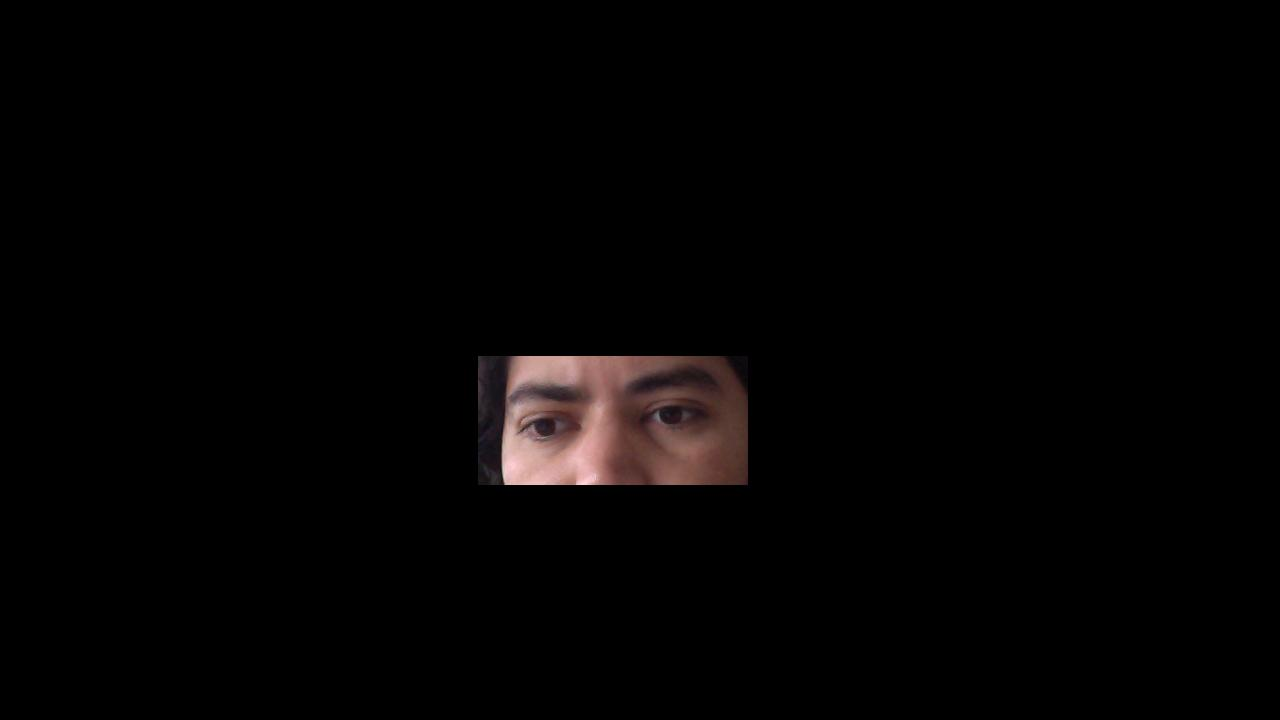

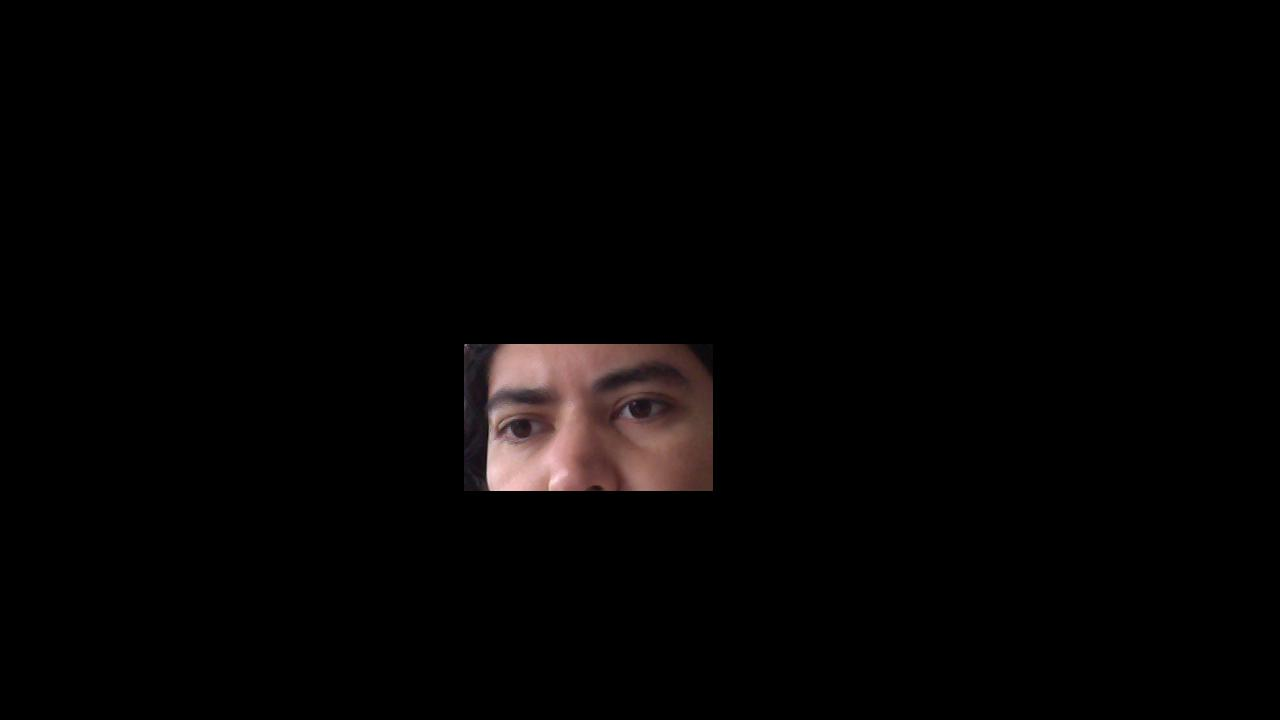

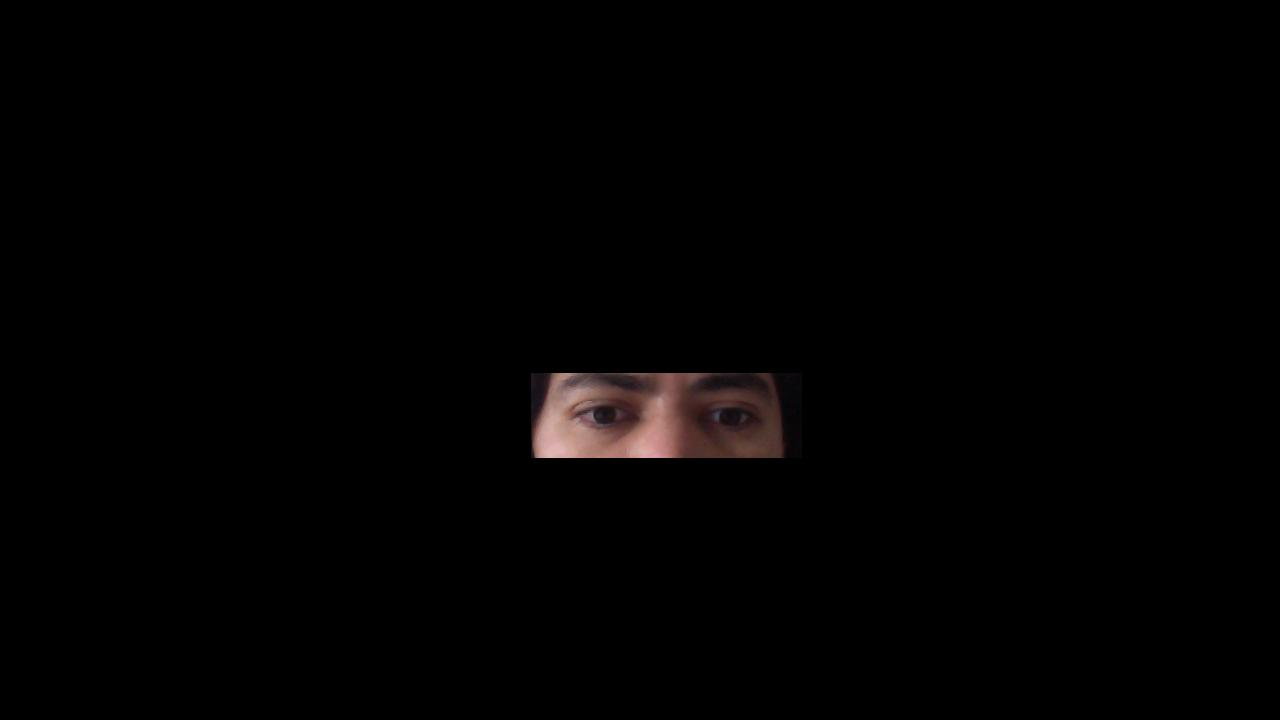

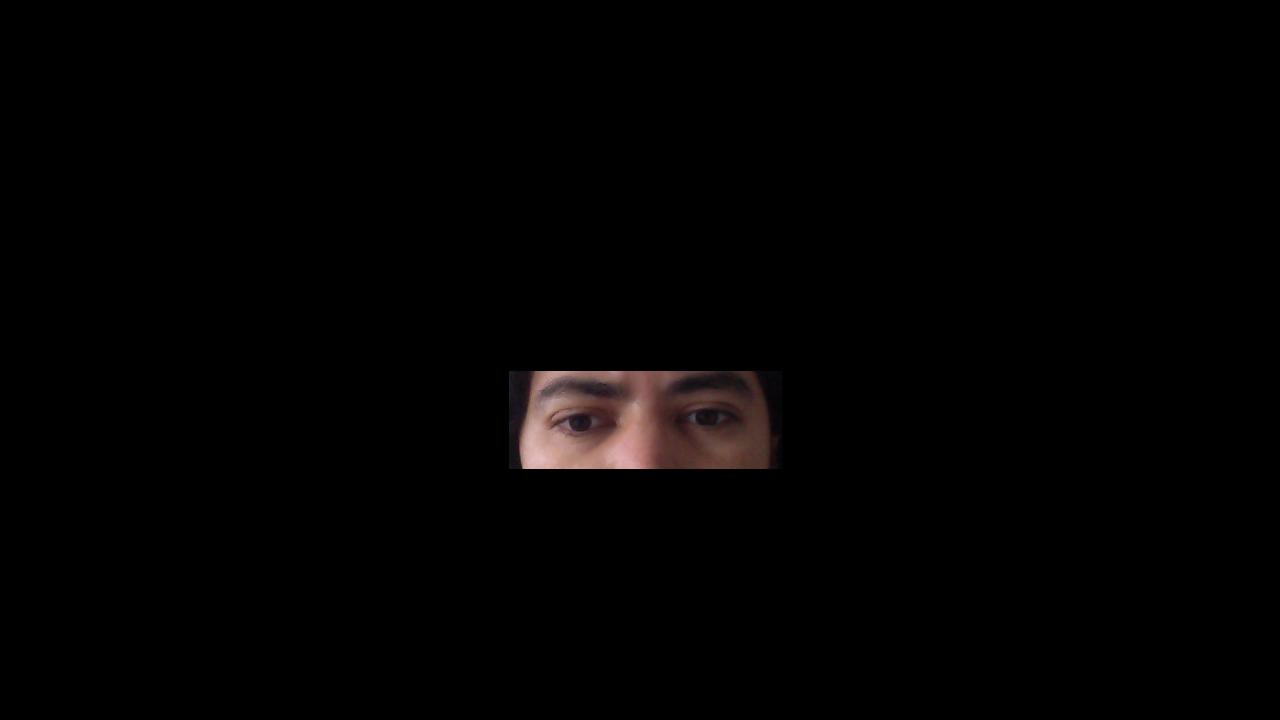

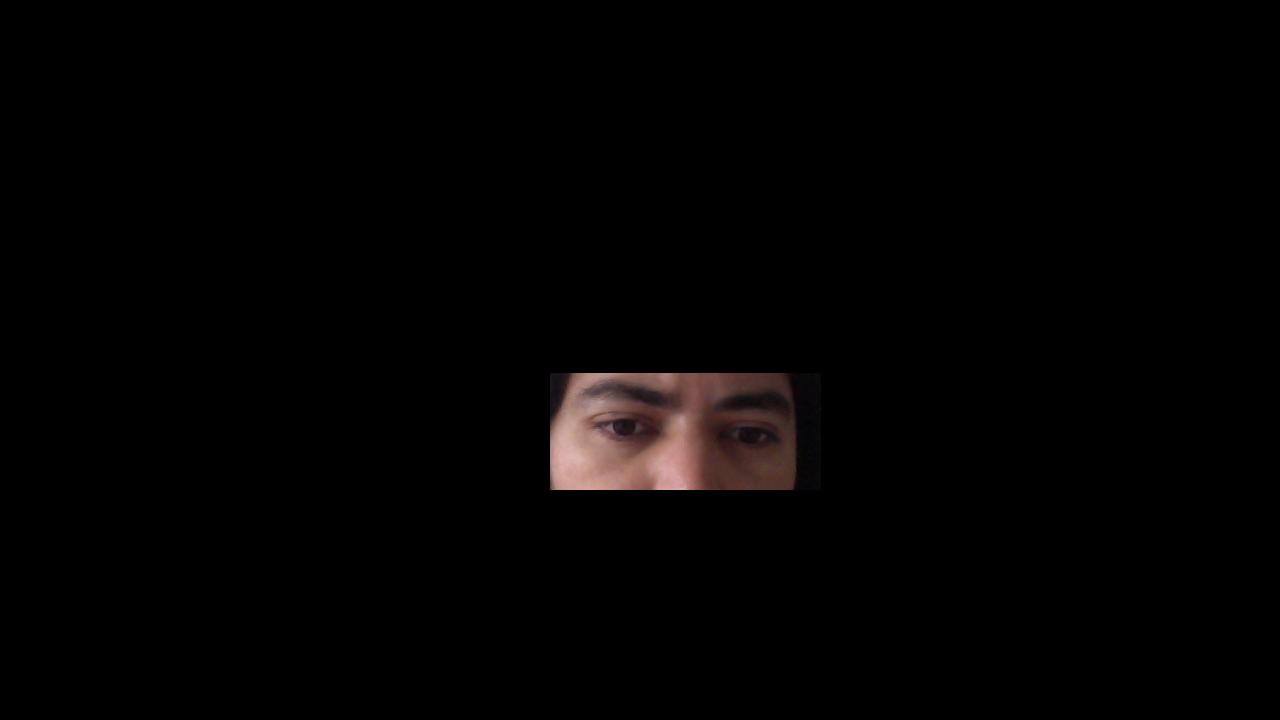

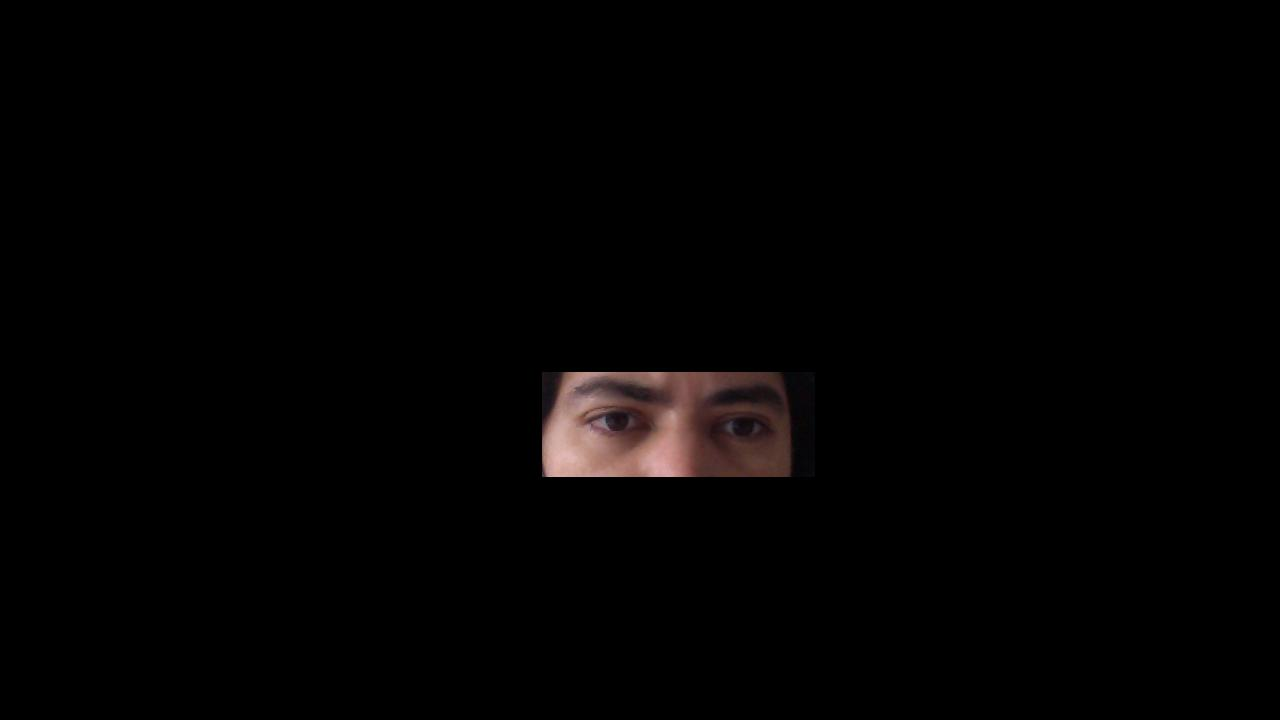

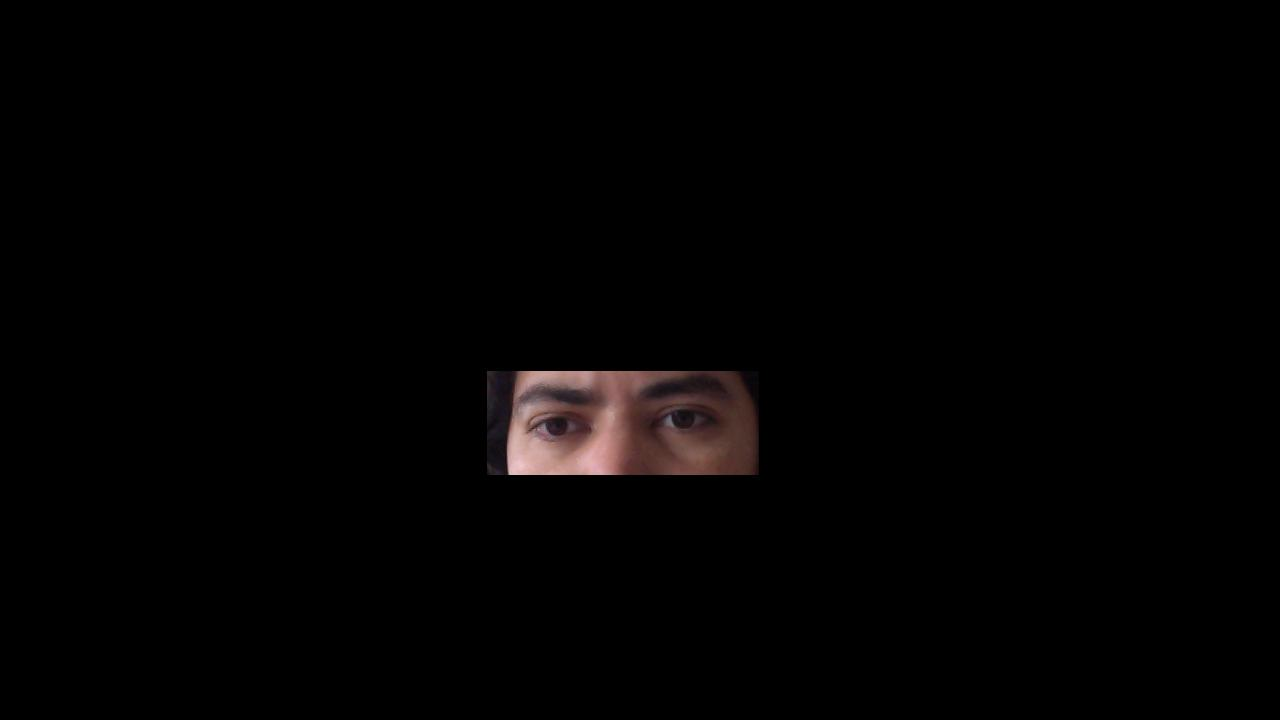

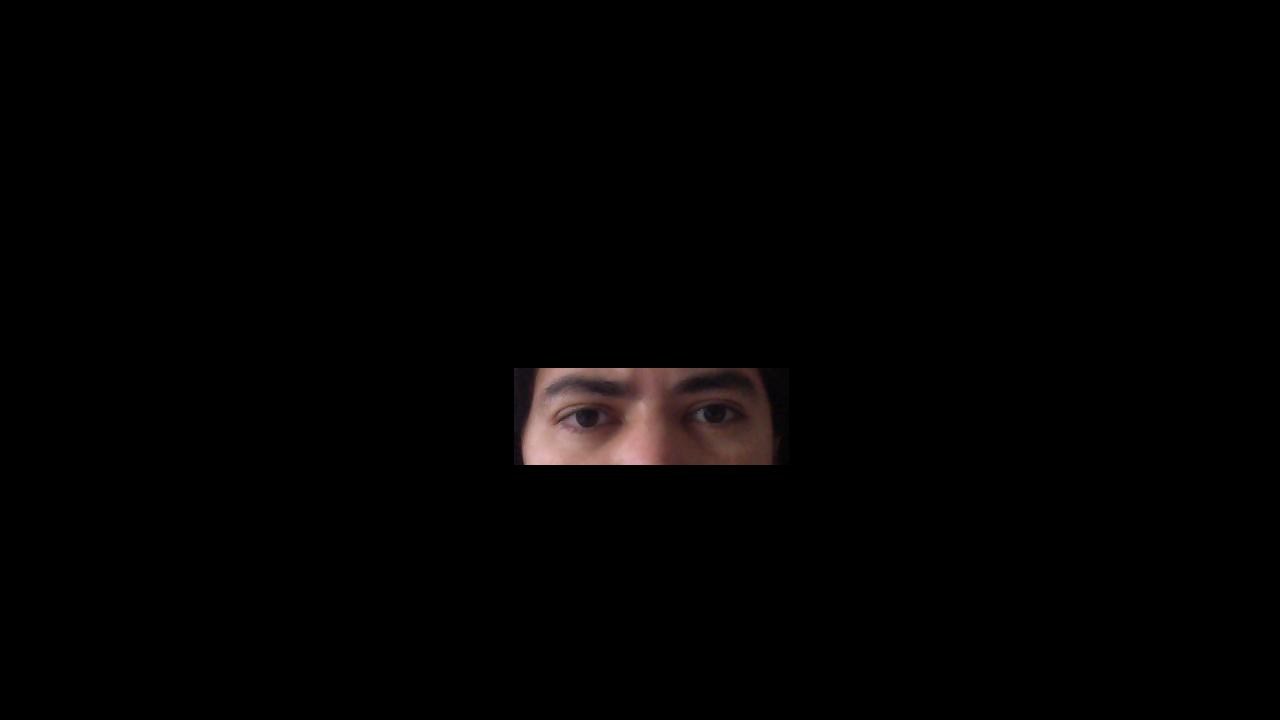

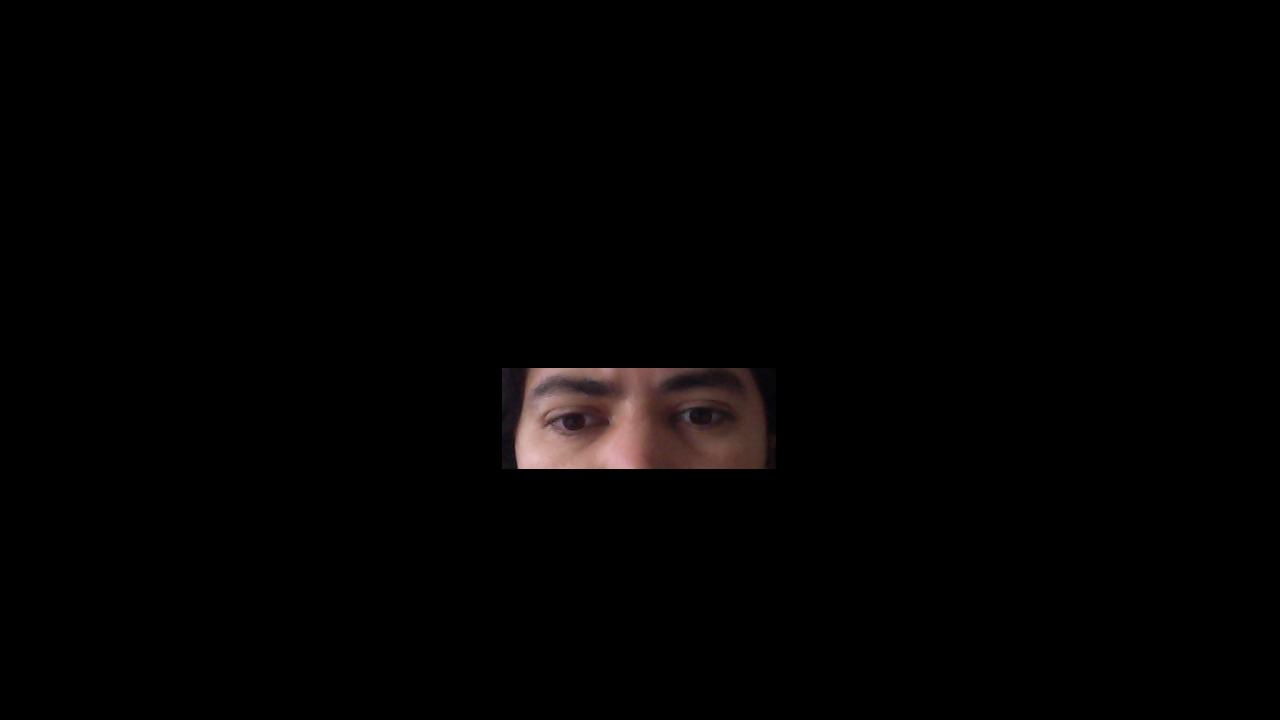

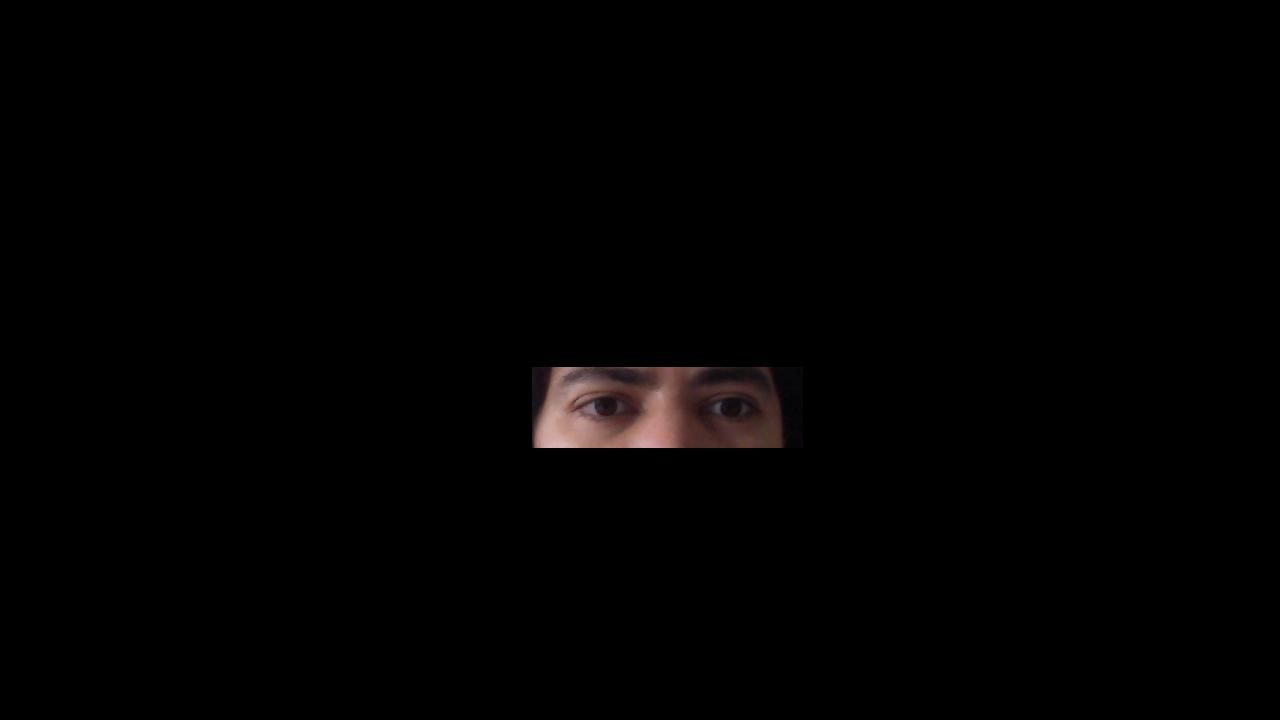

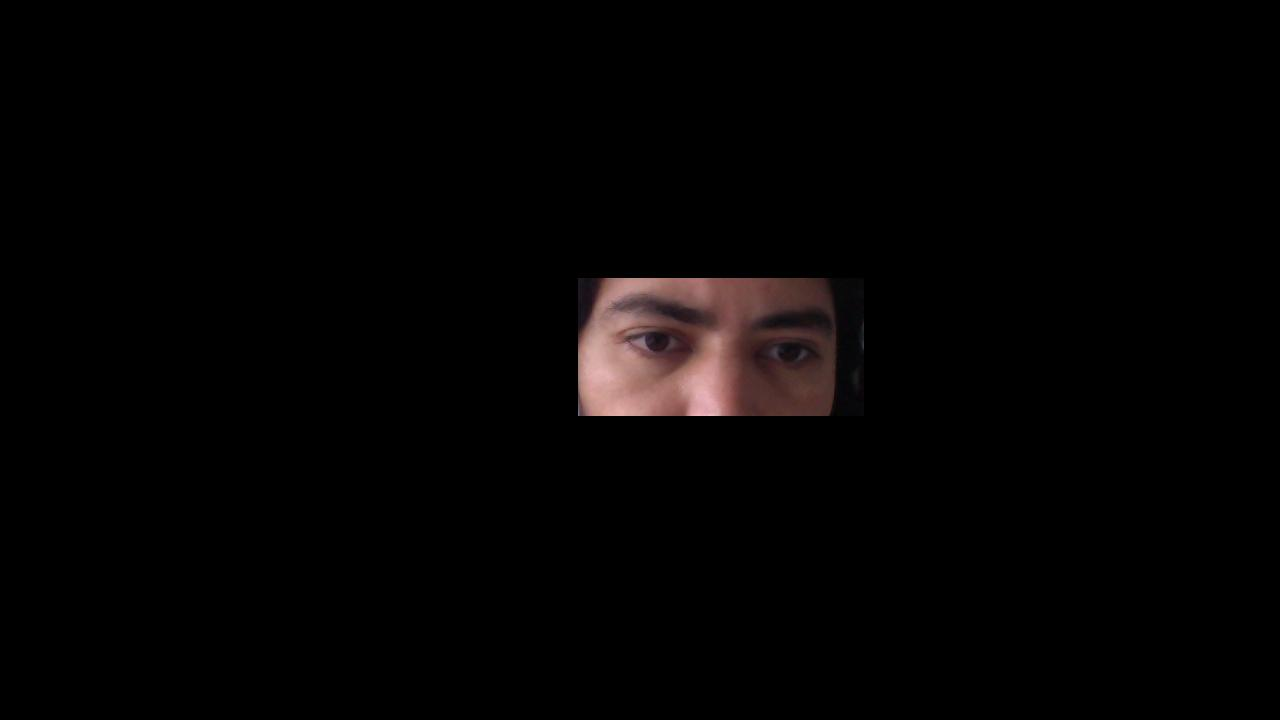

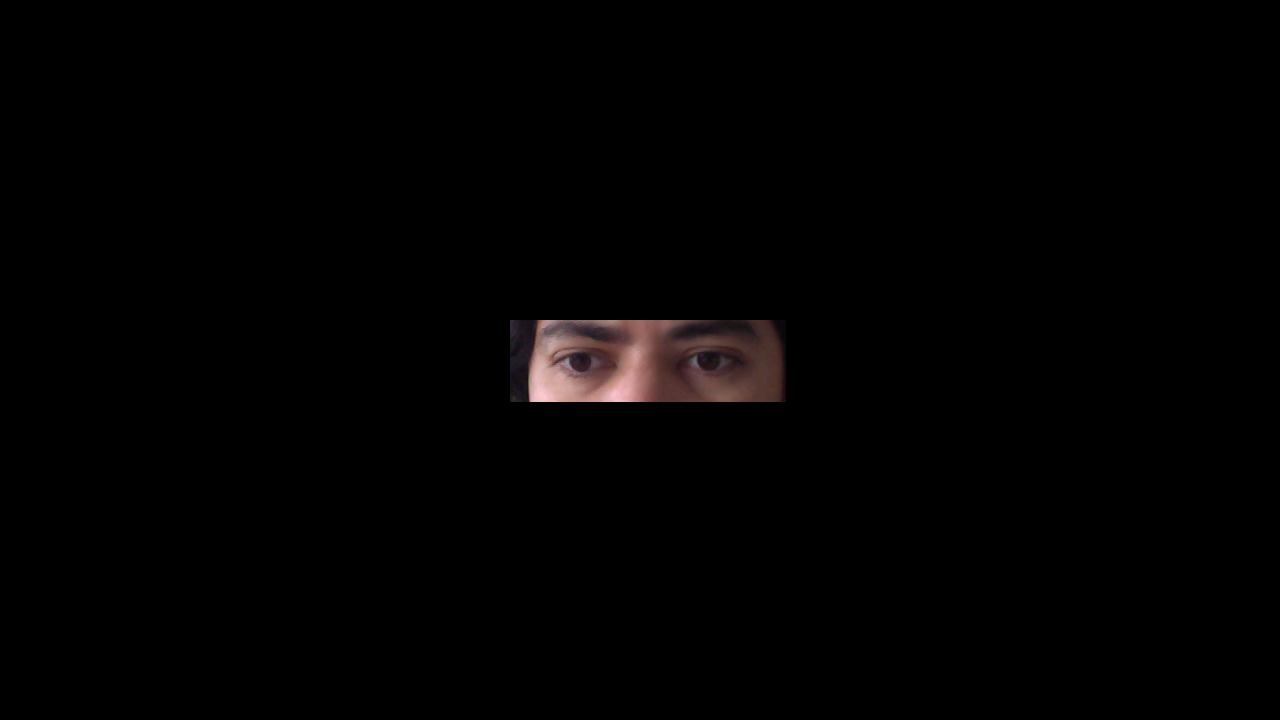

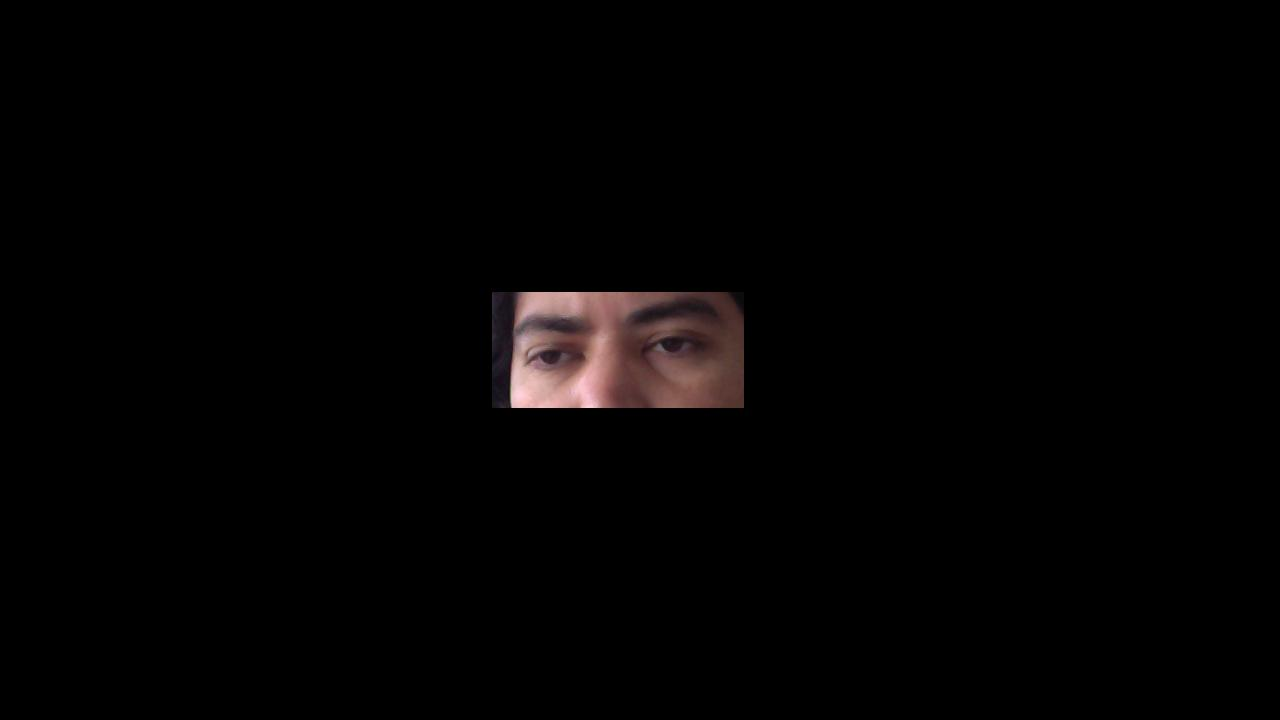

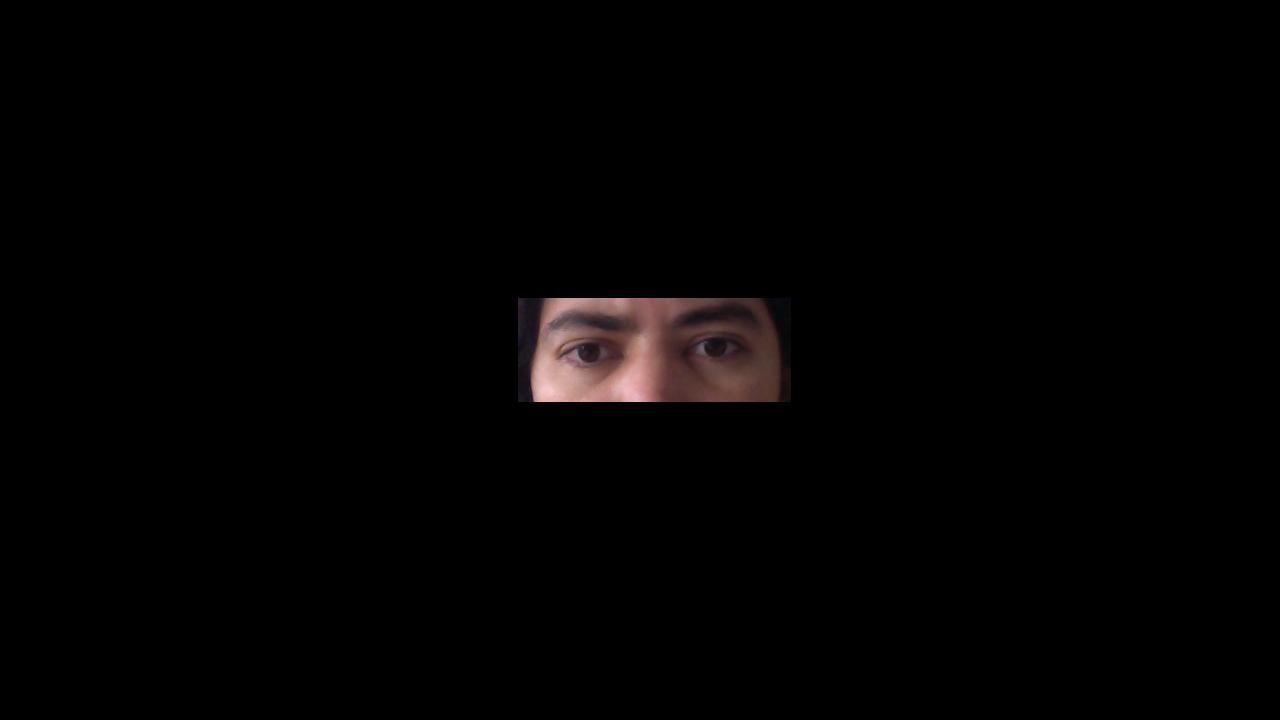

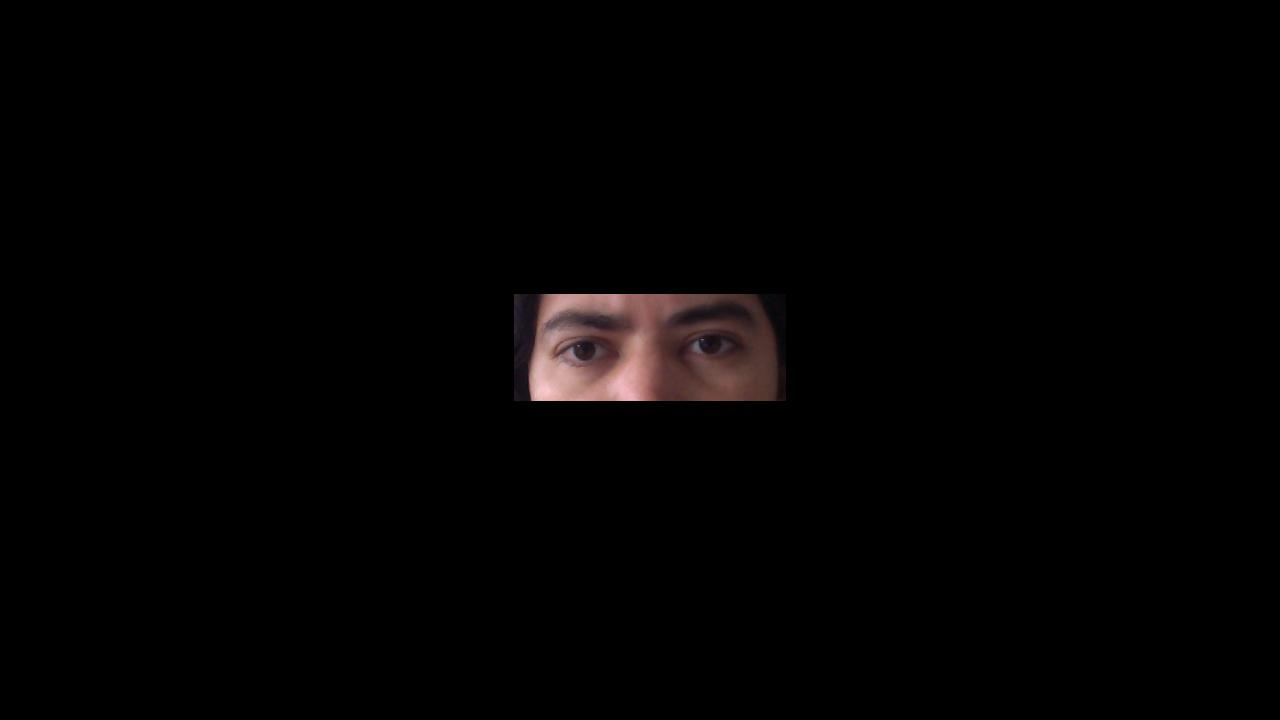

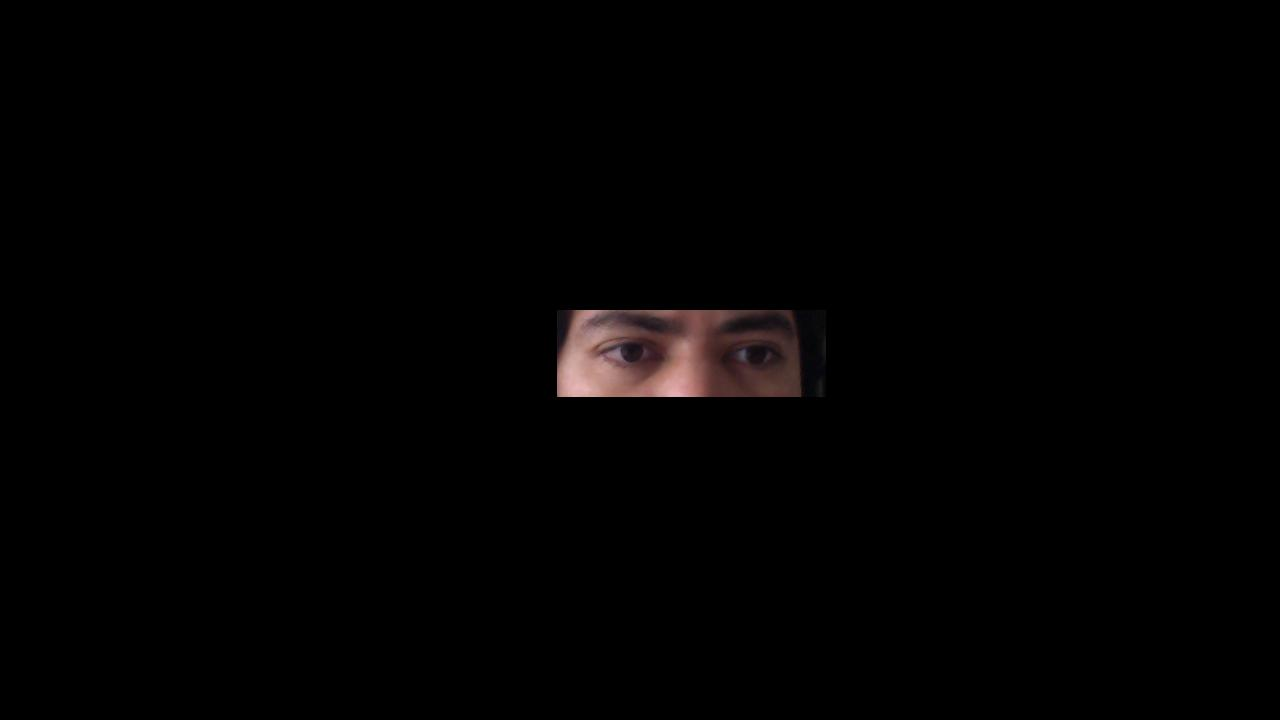

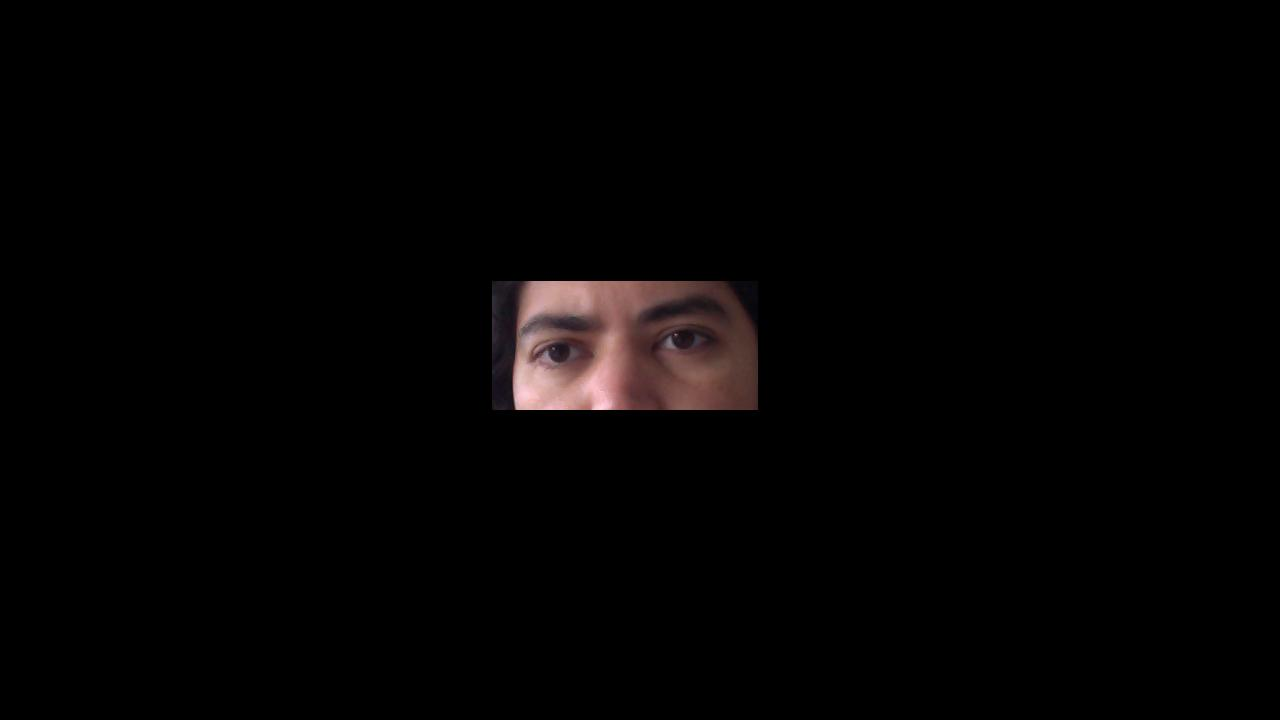

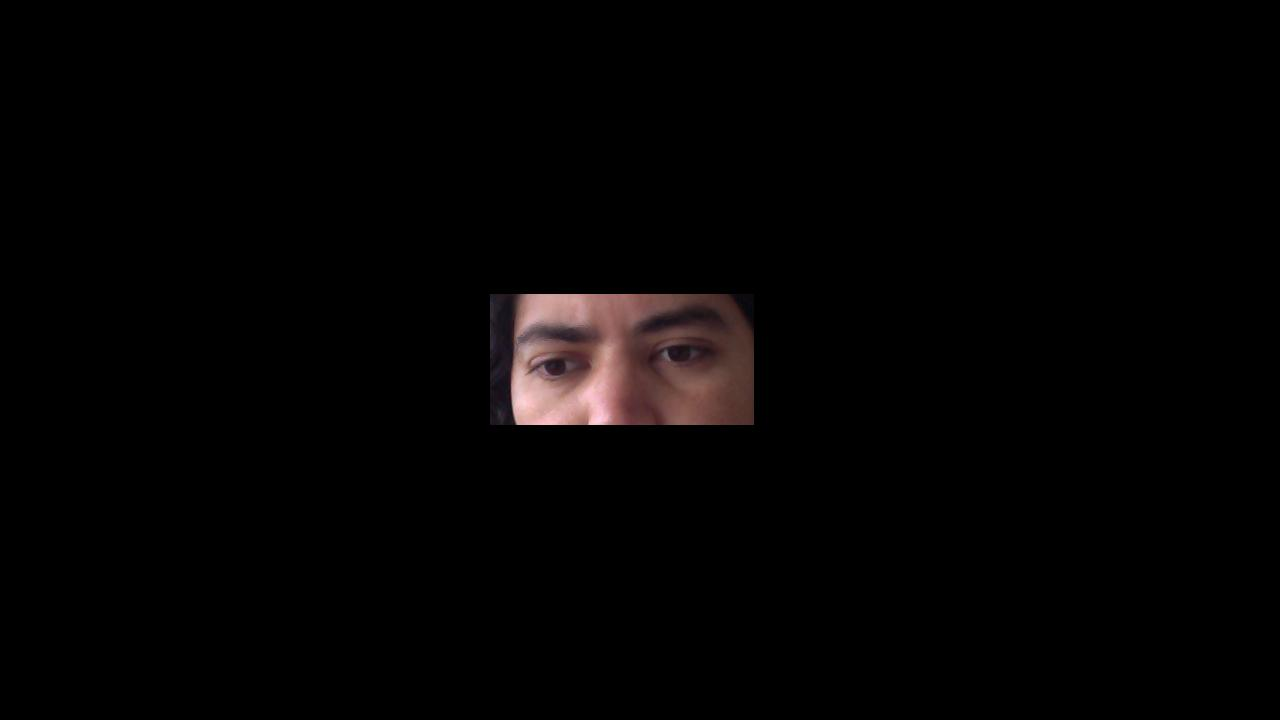

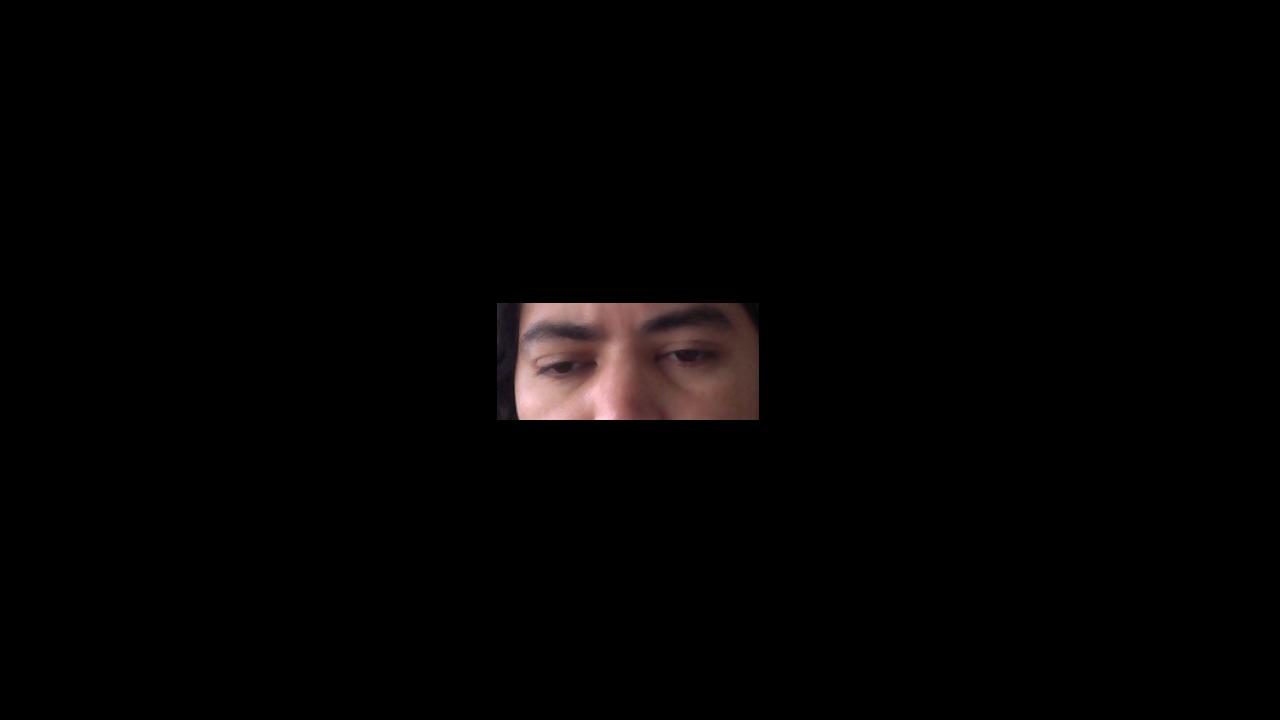

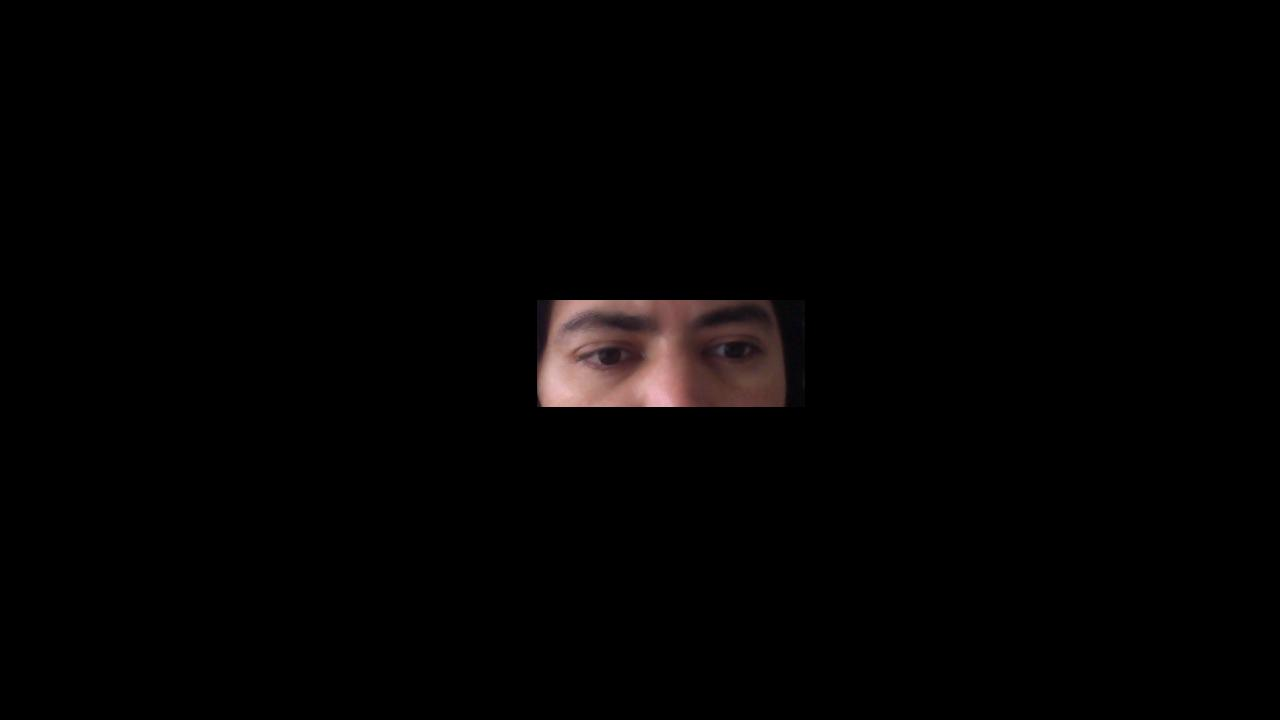

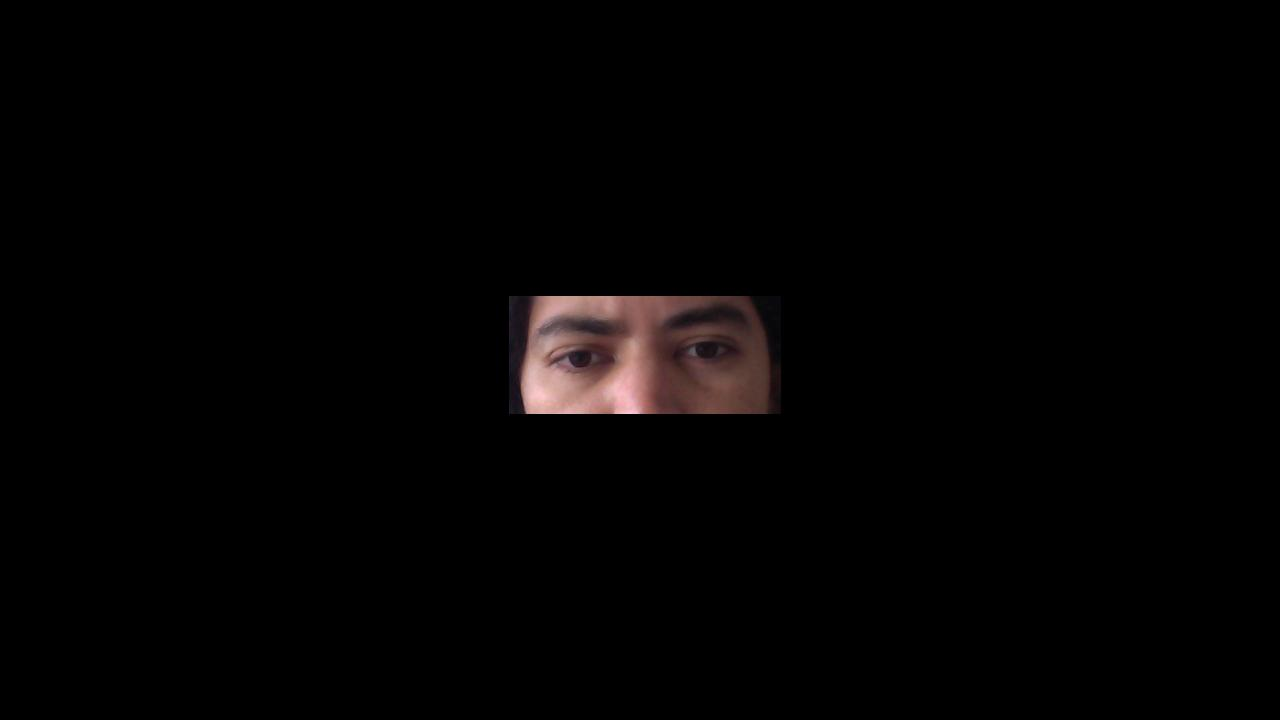

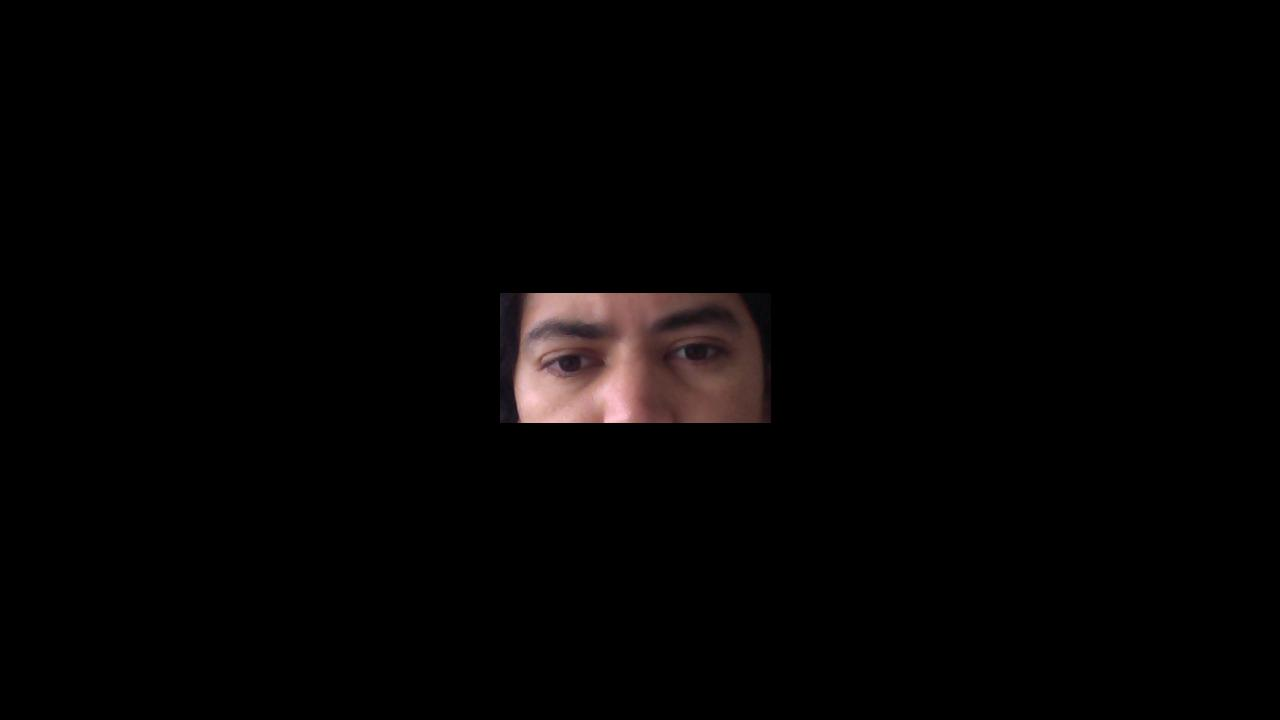

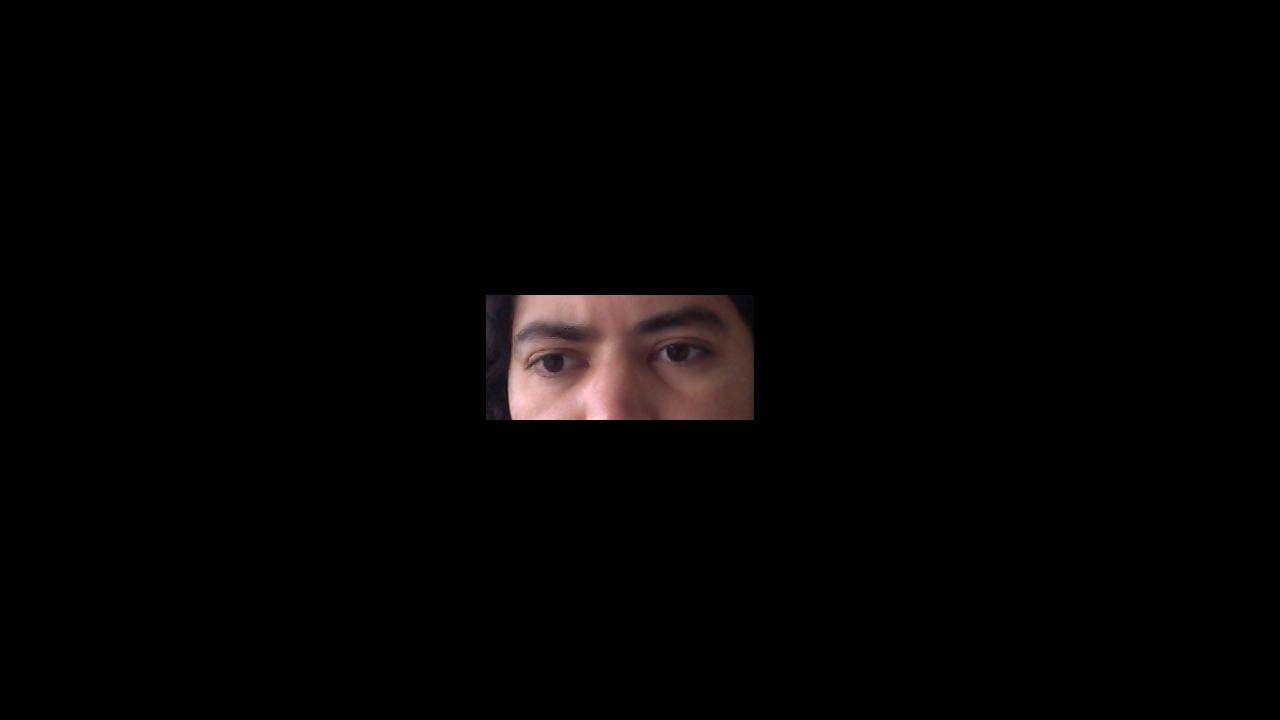

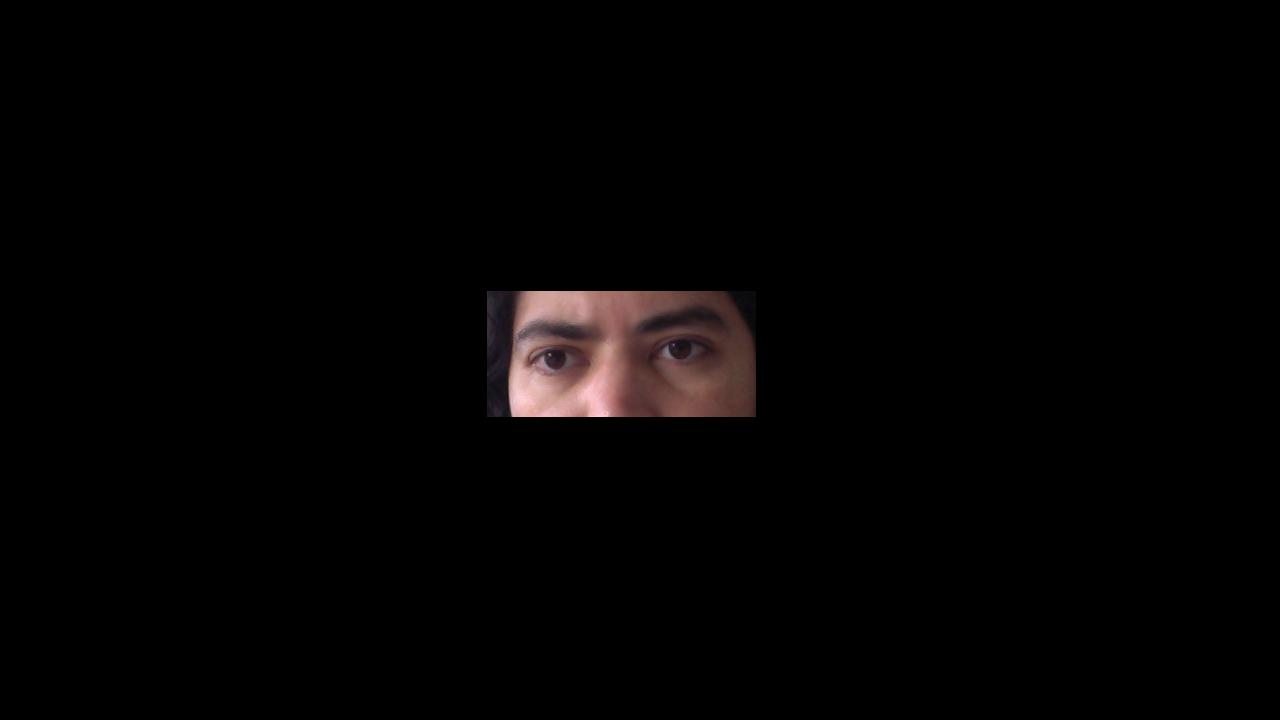

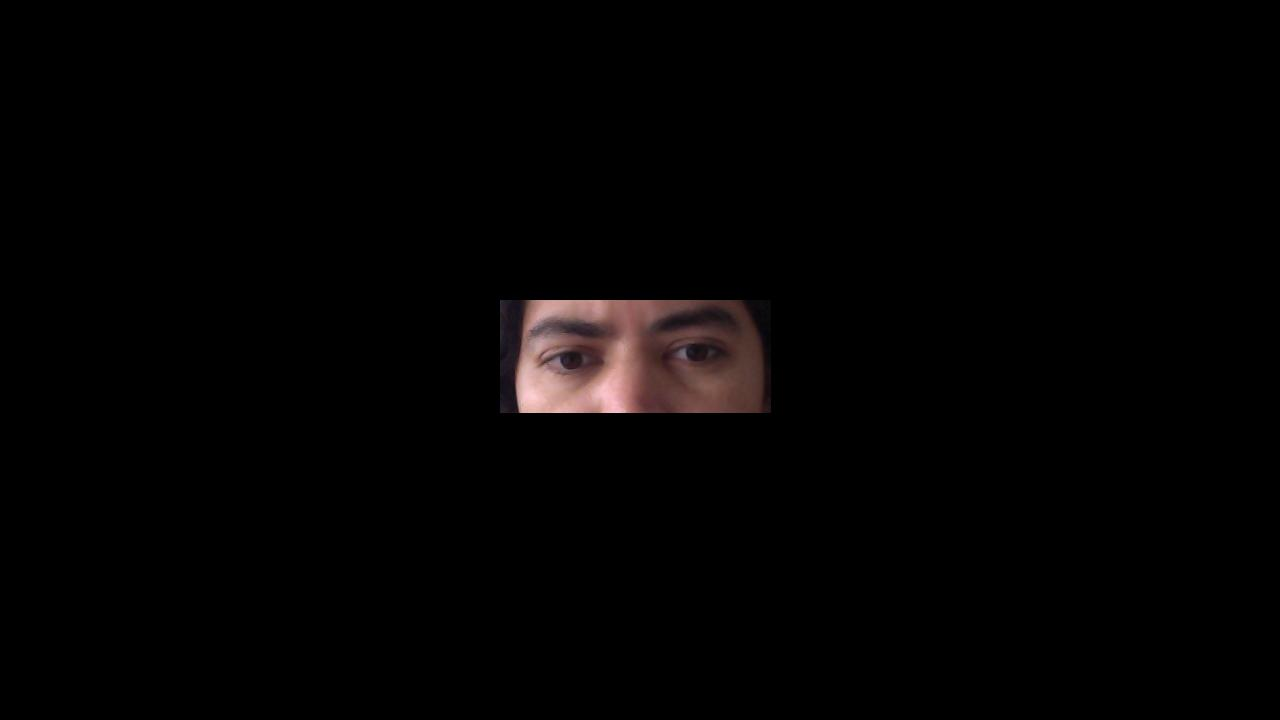

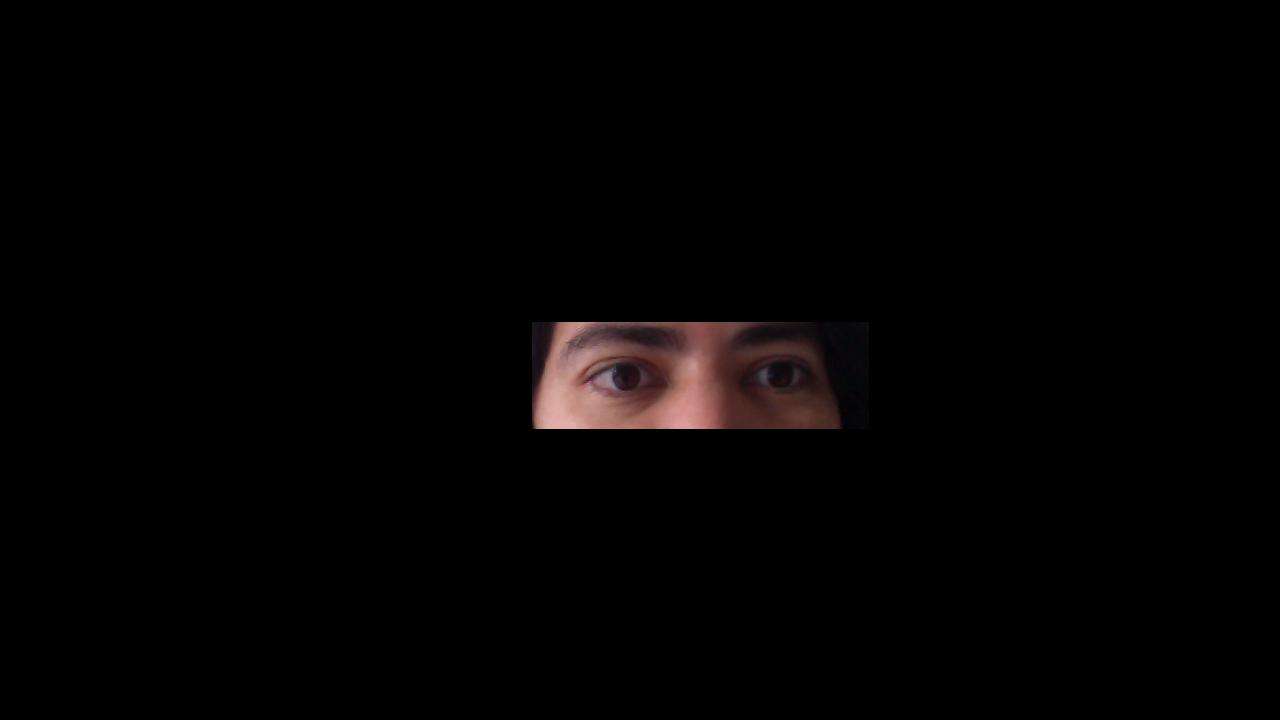

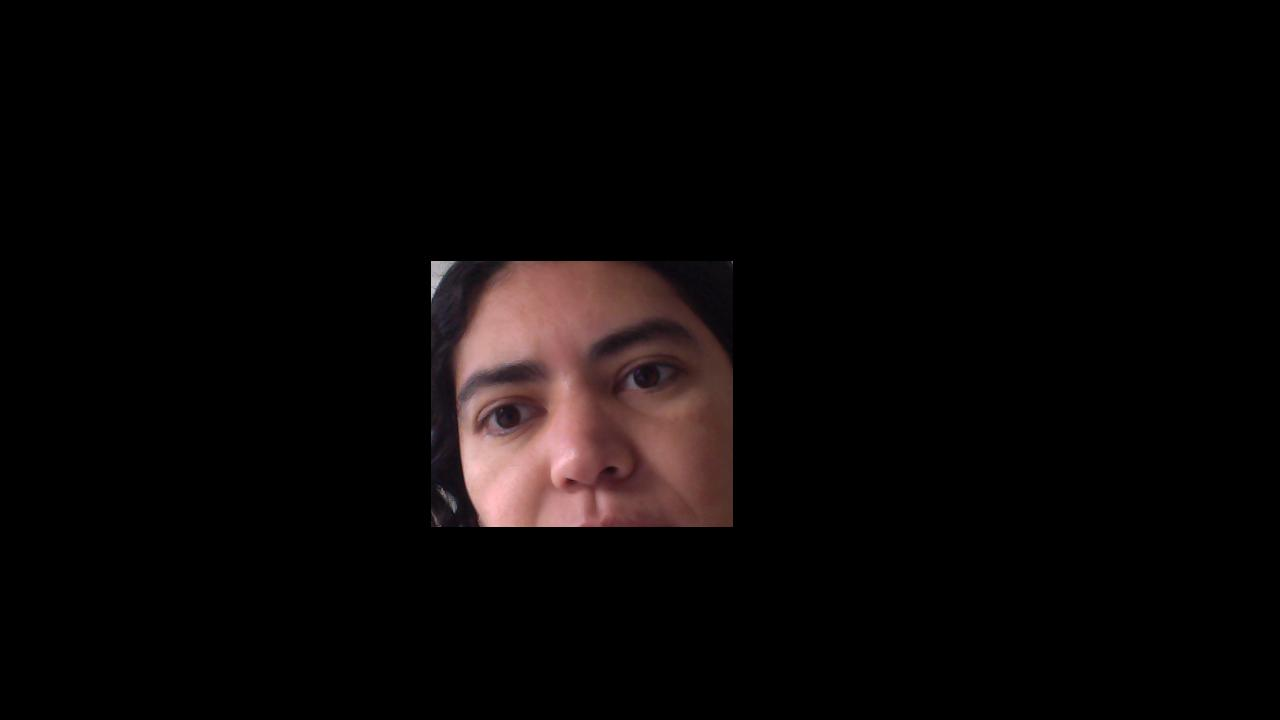

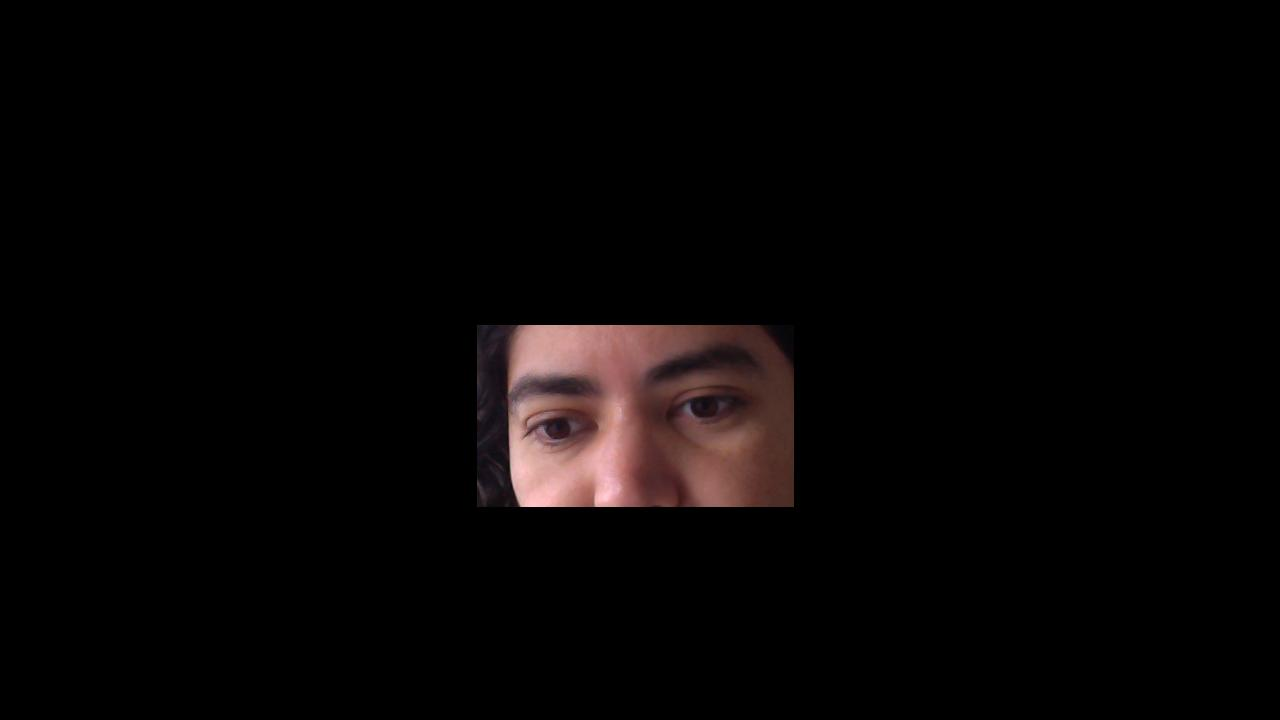

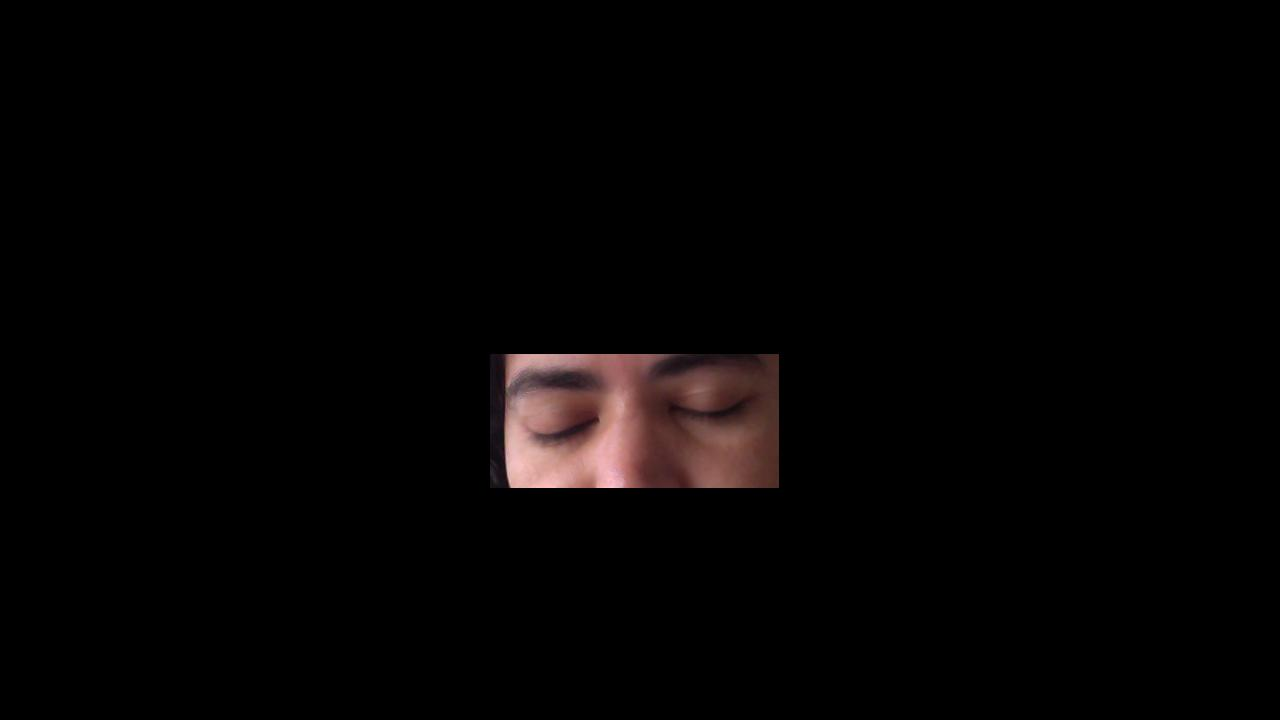

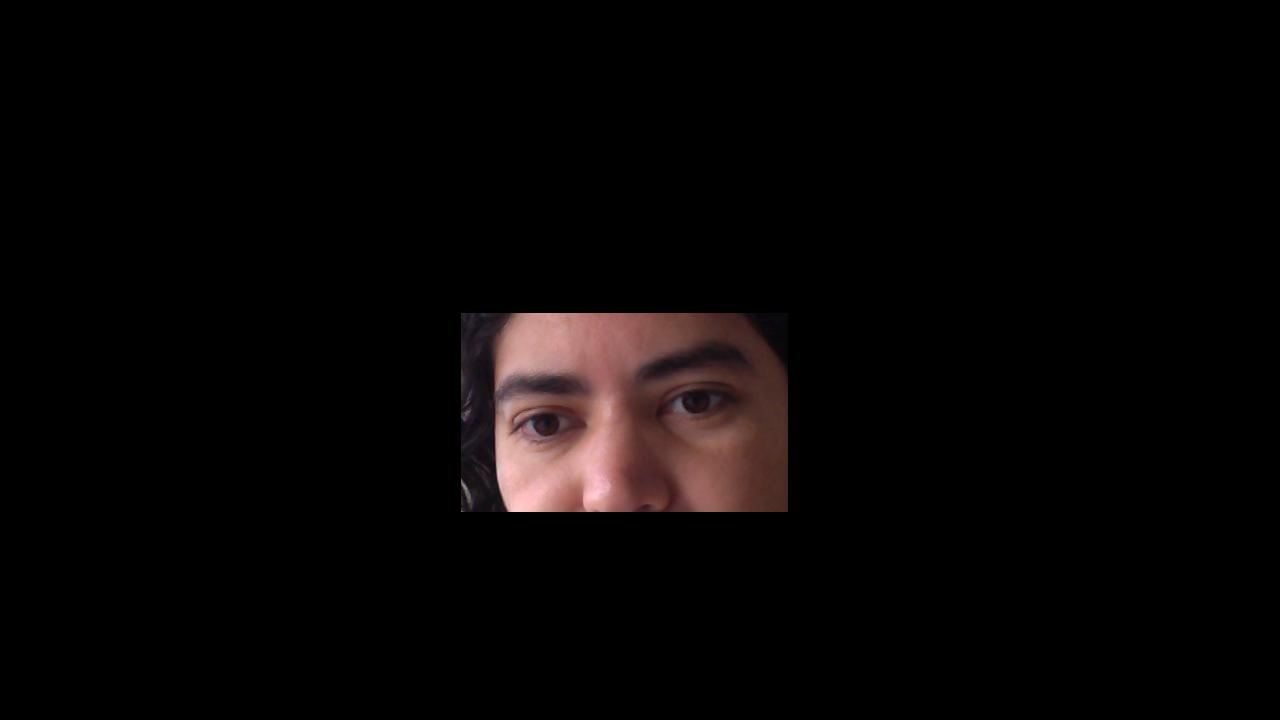

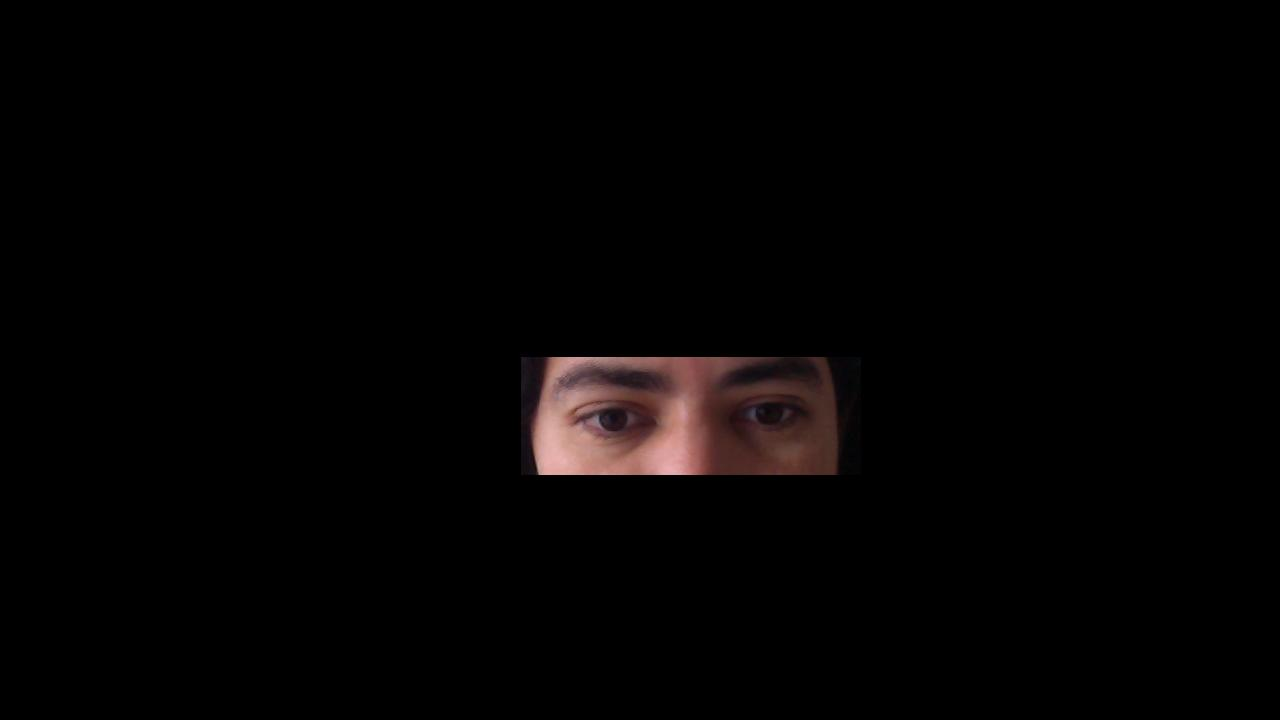

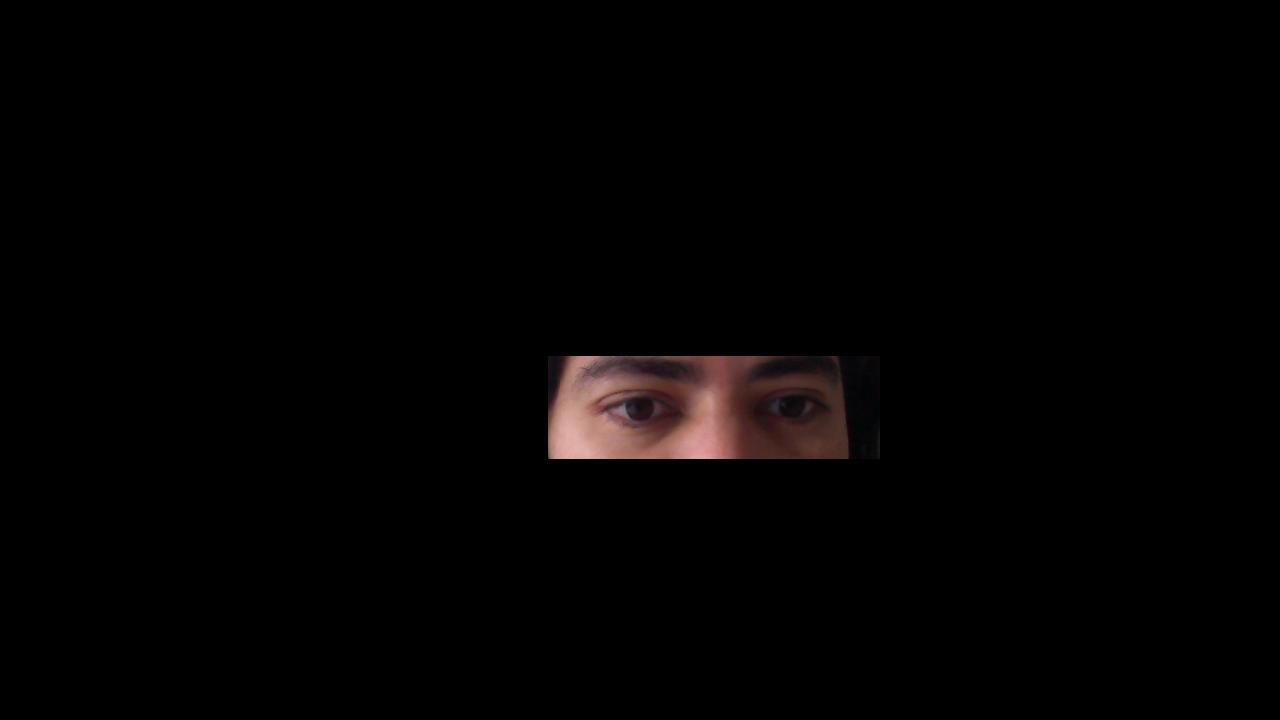

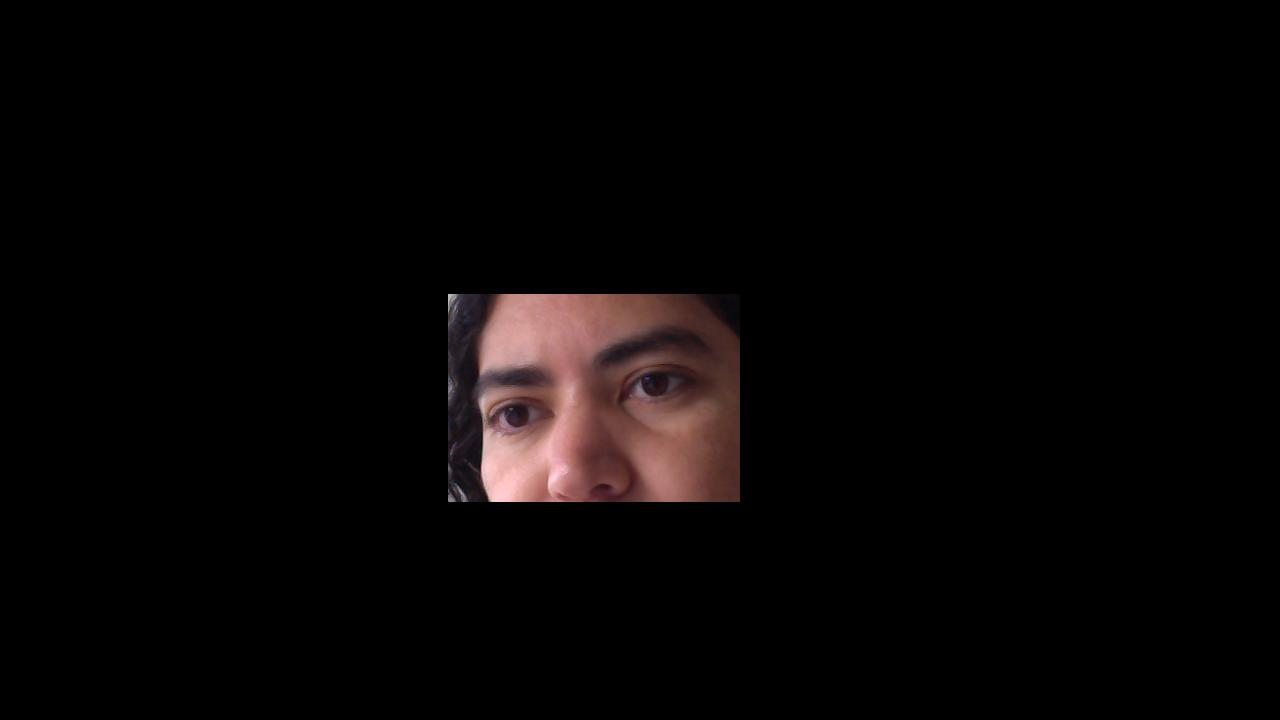

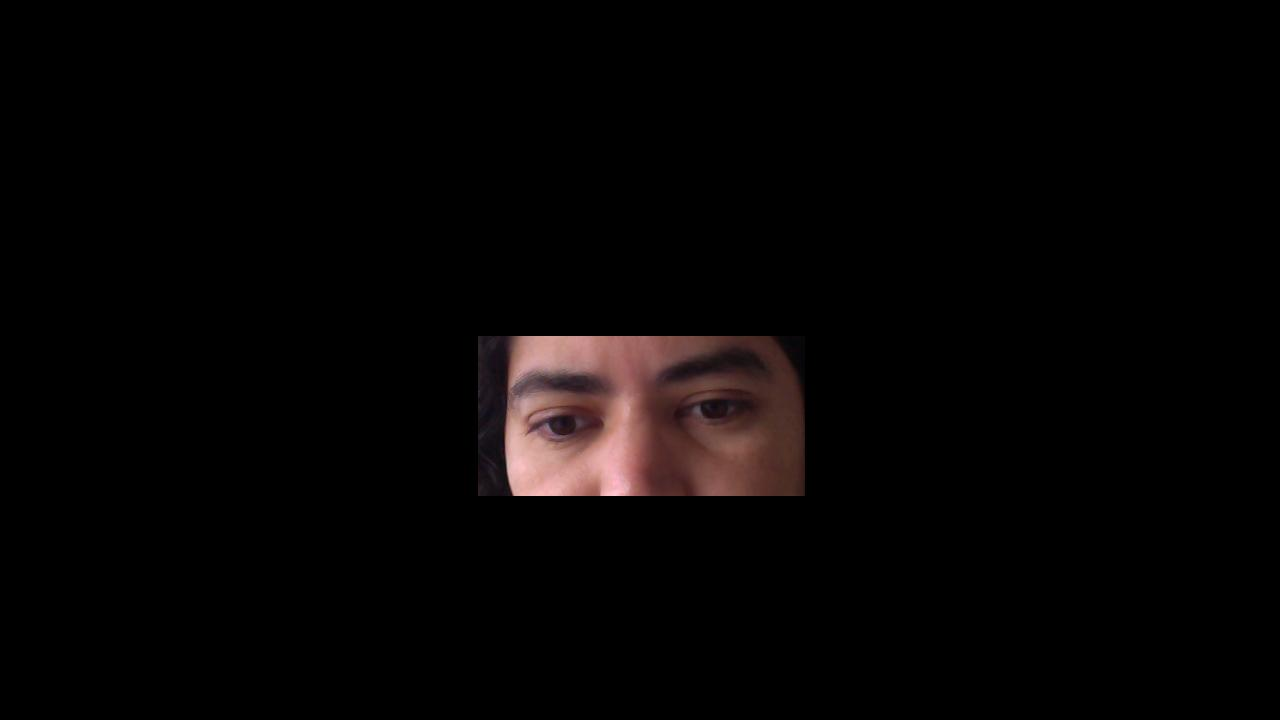

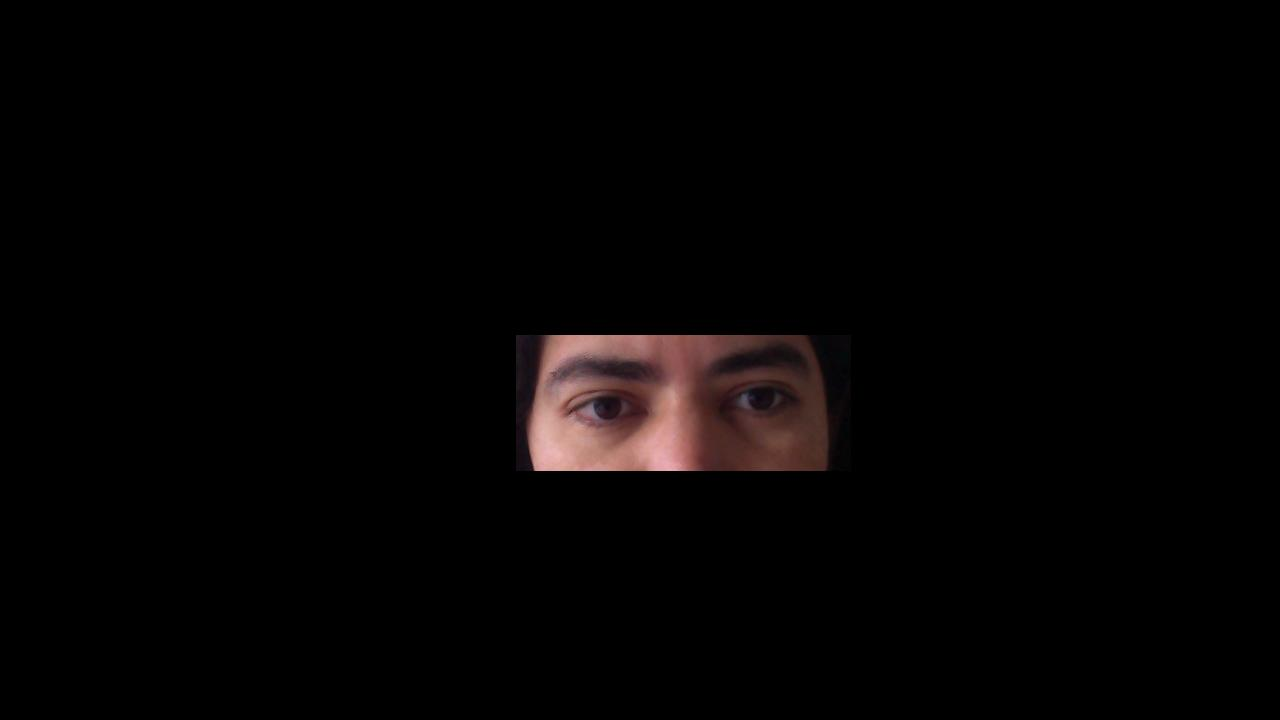

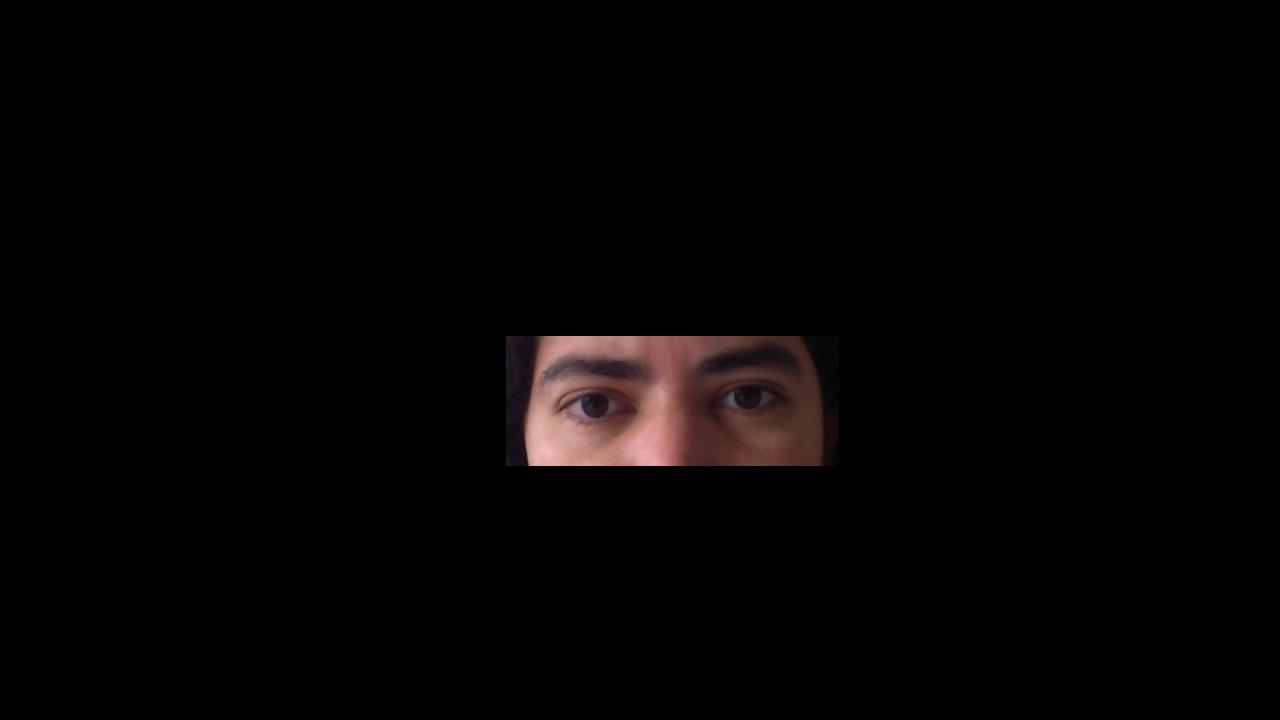

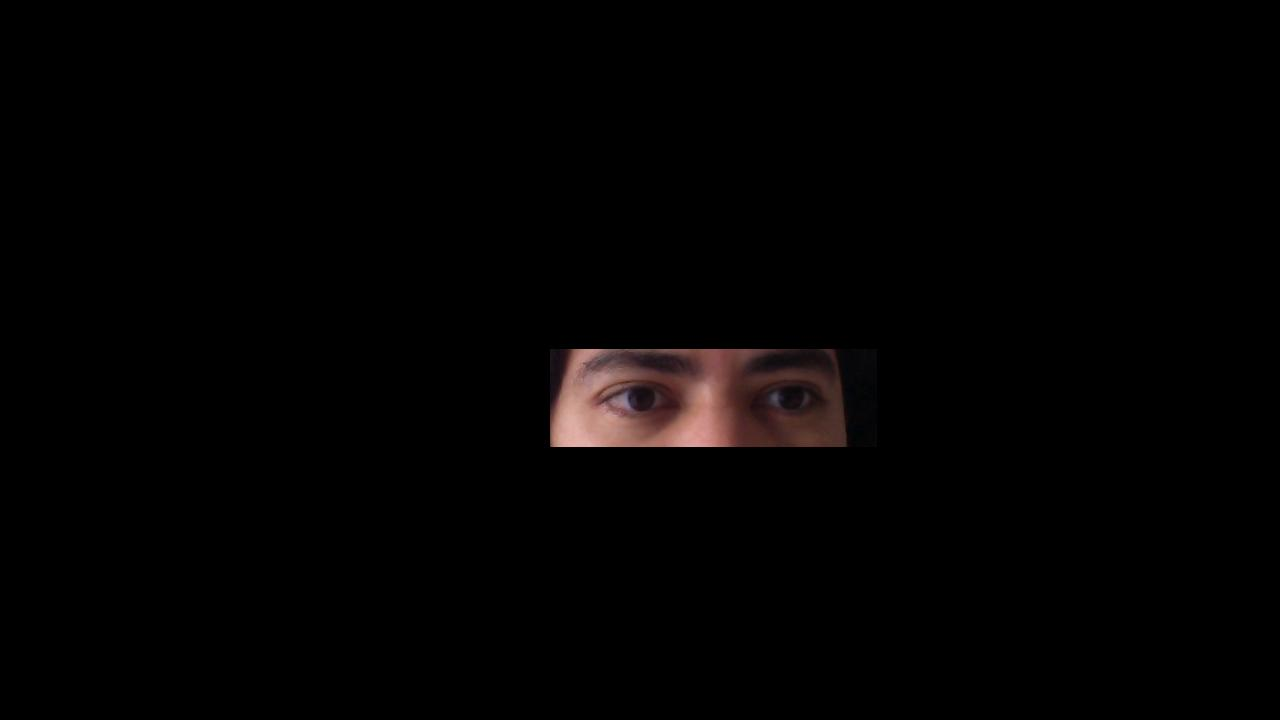

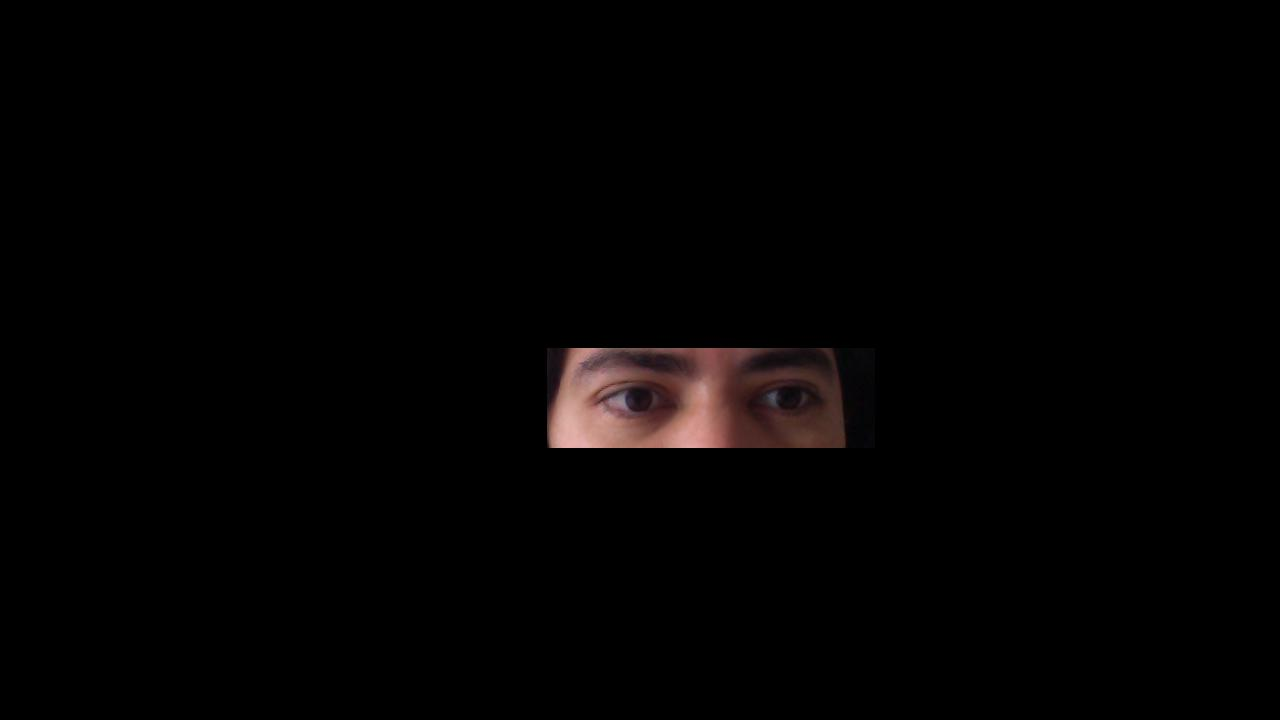

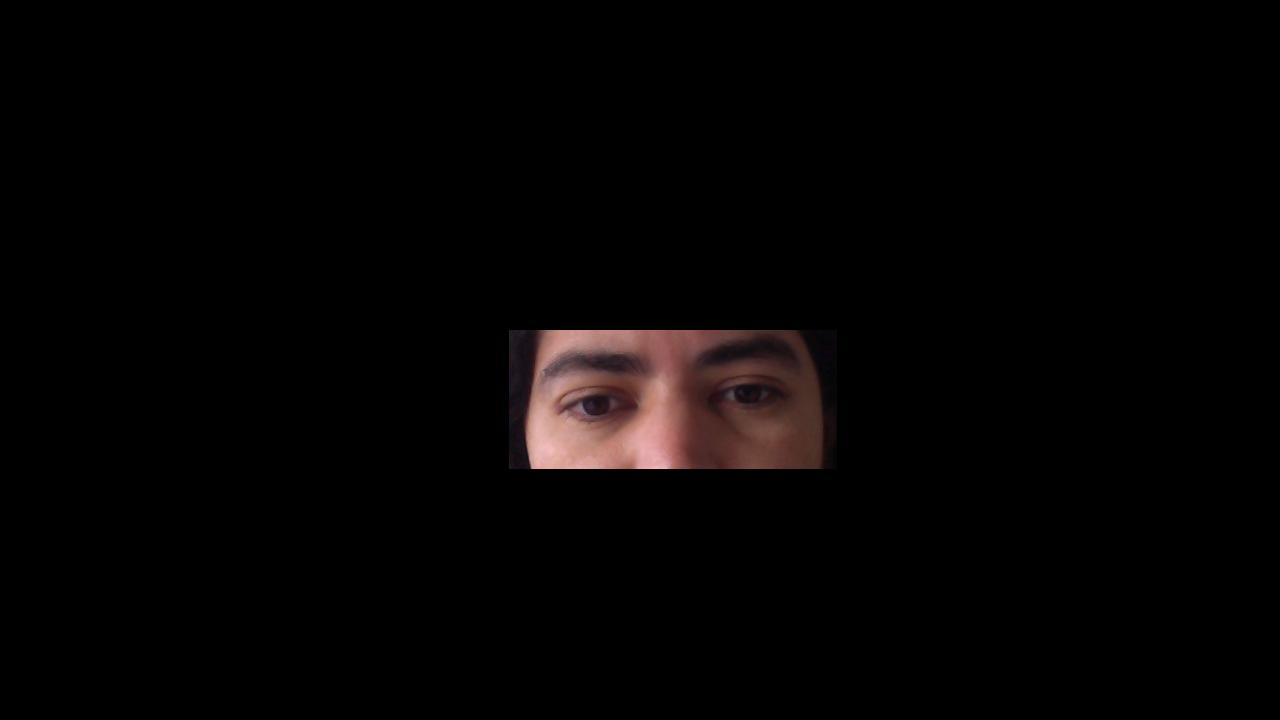

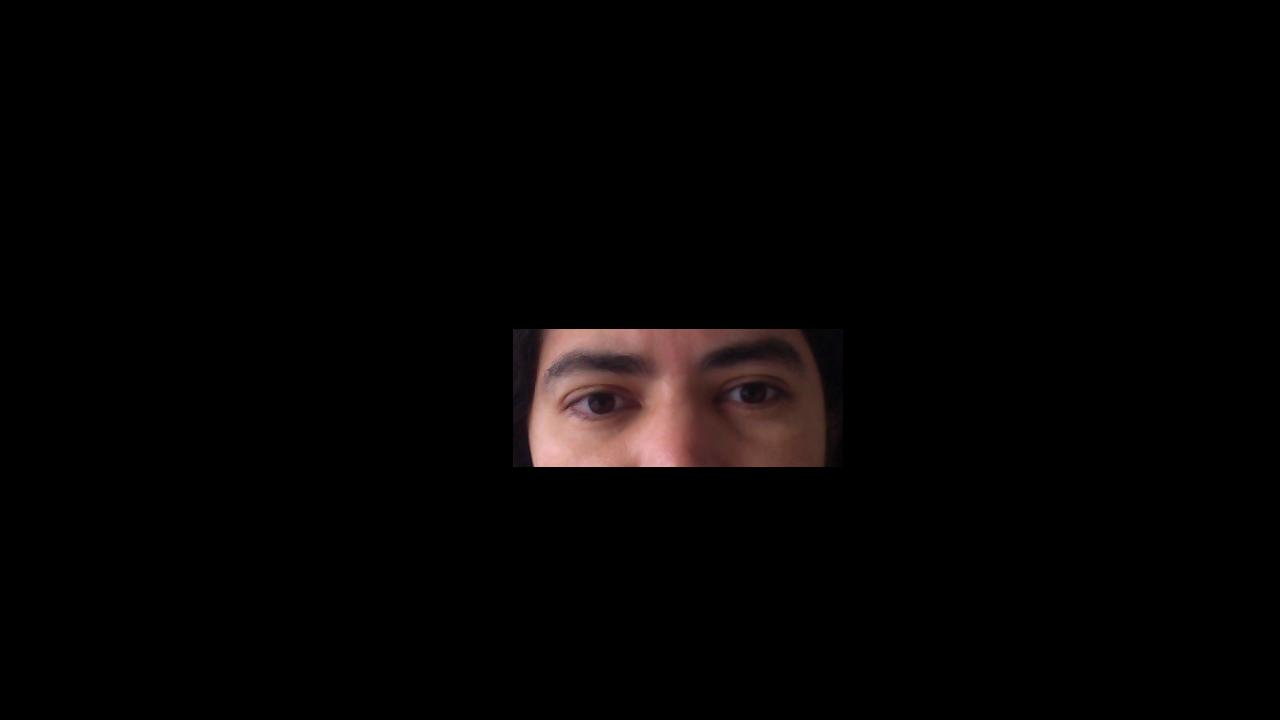

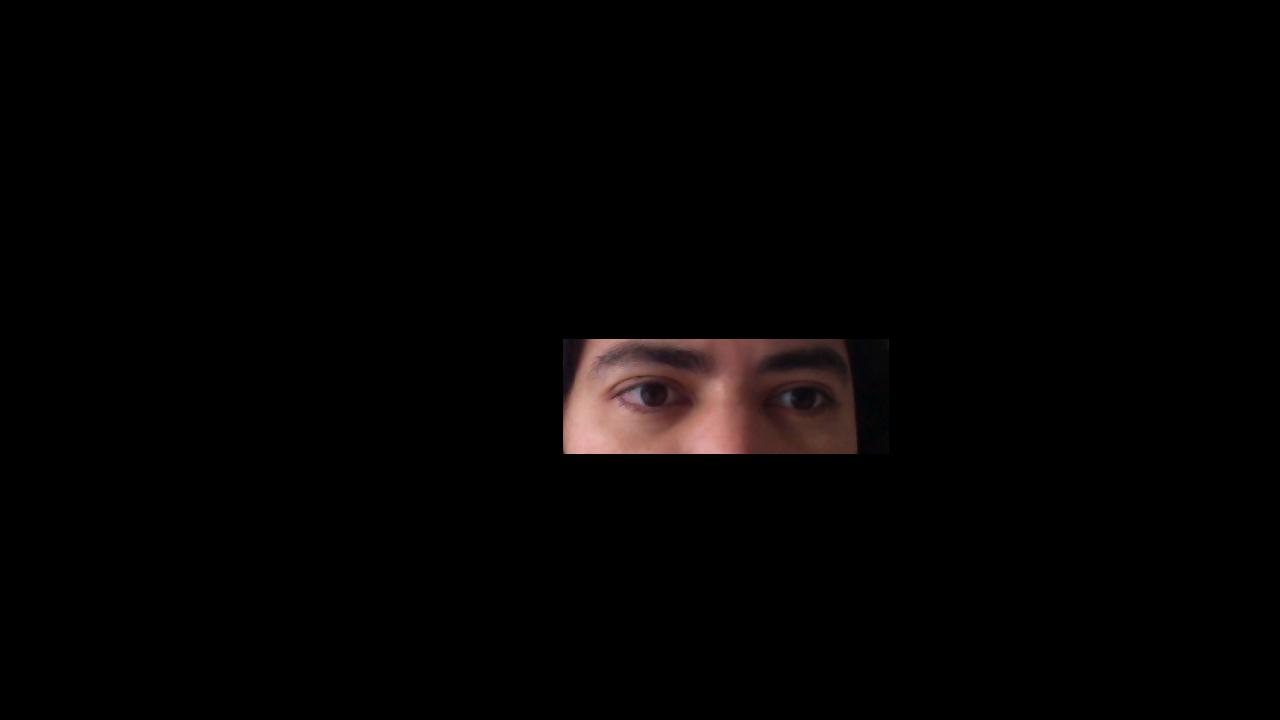

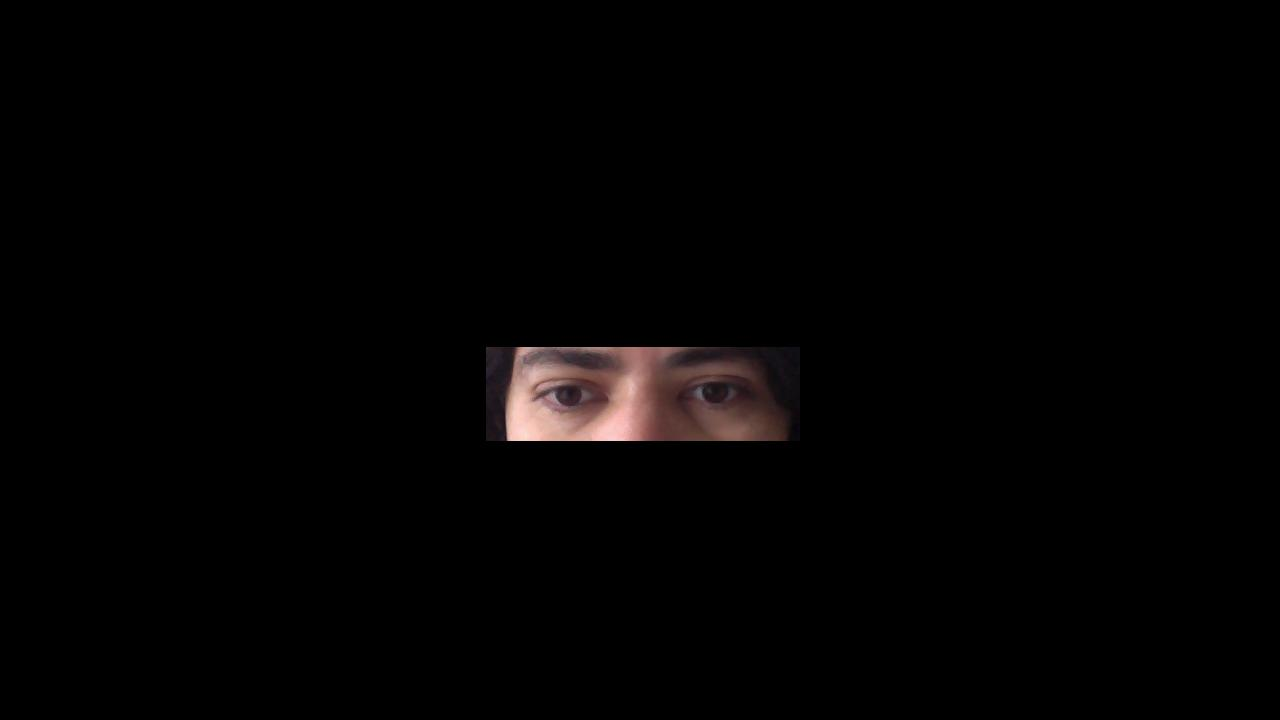

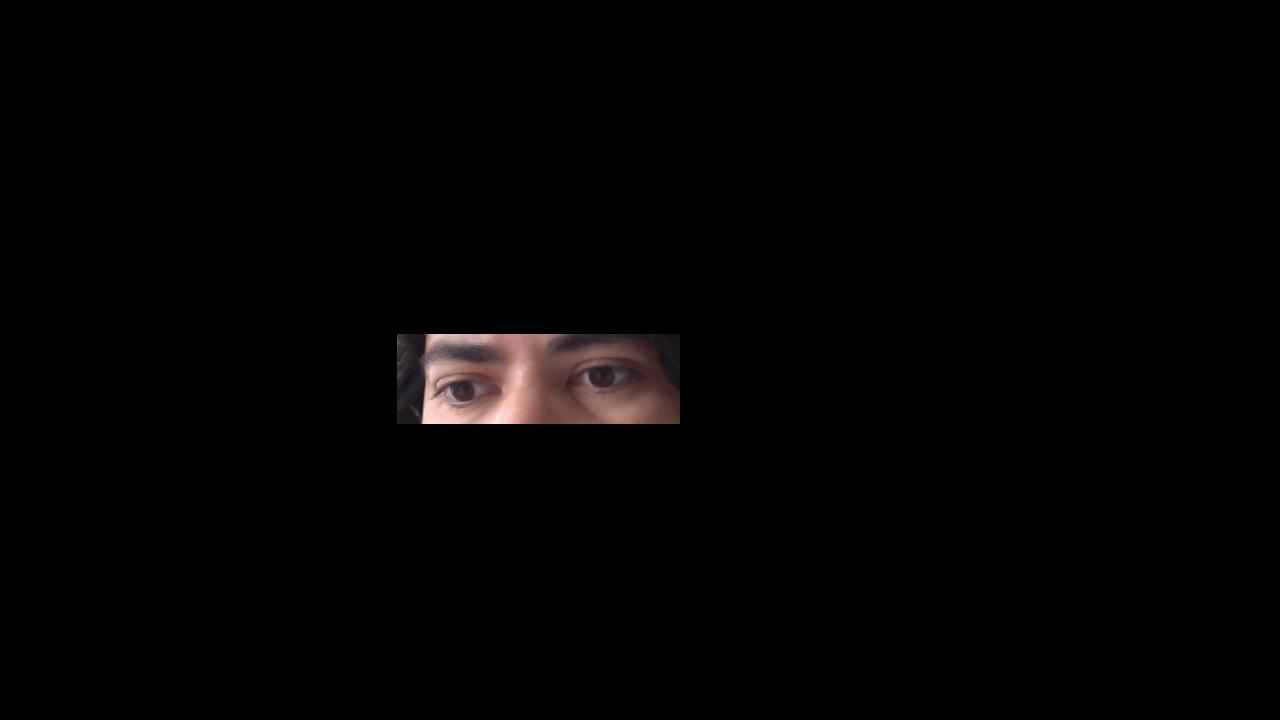

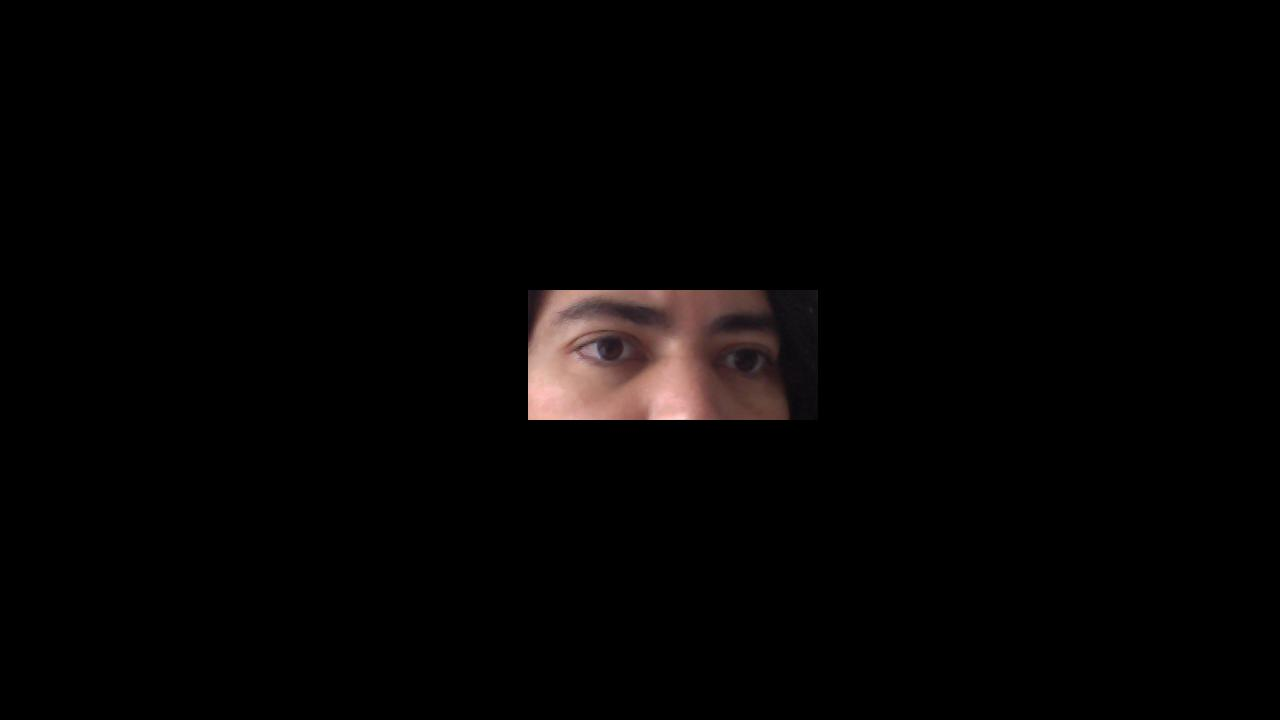

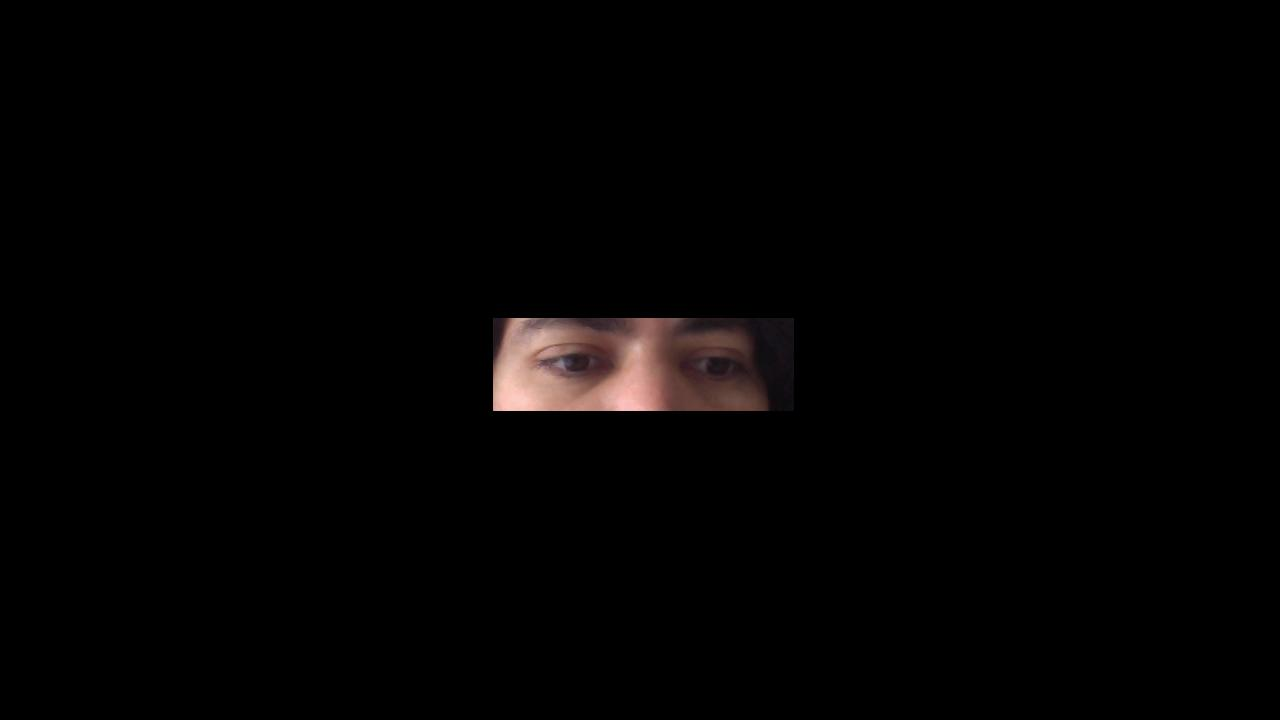

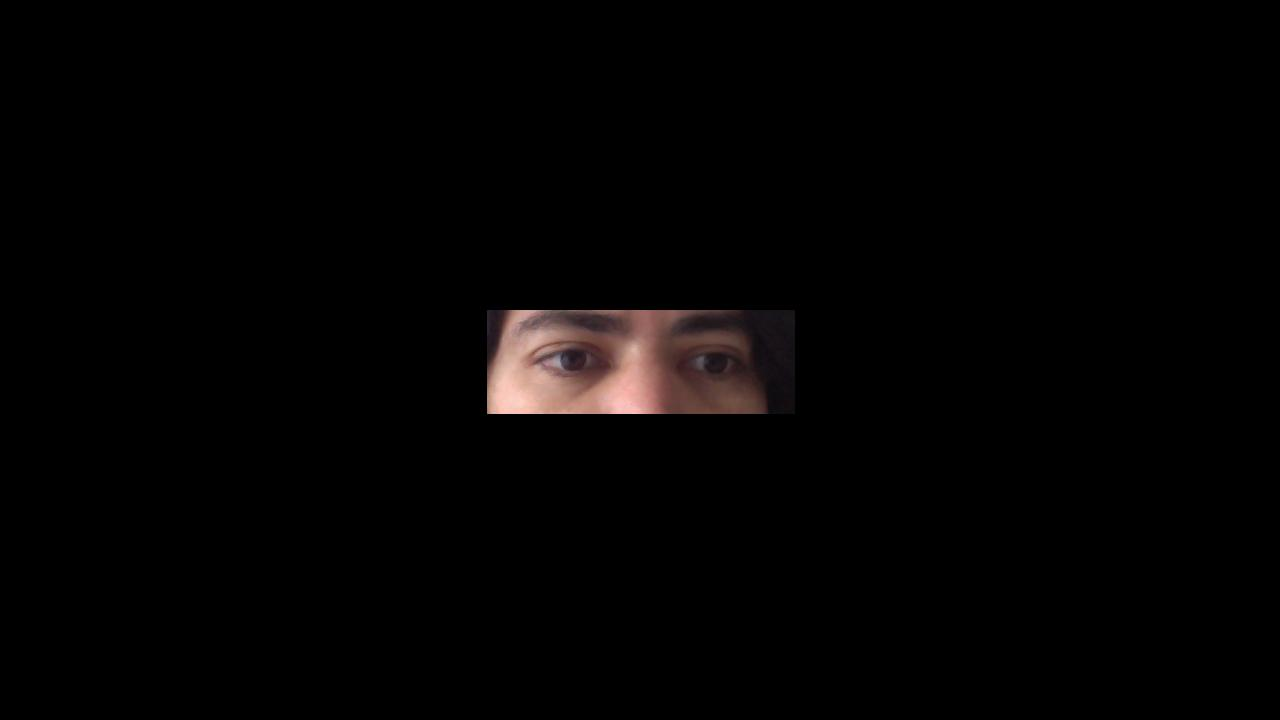

In [69]:
for path in unlocked_path_list[:100]:
    imshow_path(path)
